# ===   EDA. Predict rating hotels  ===

## Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import chi2, f_classif
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary resources for sentiment analysis
nltk.download('vader_lexicon')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Load and Combine Train and Test Data

In [2]:
DATA_DIR = '/kaggle/input/sf-booking/'

df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')



# Initial Exploration & Cleaning

In [3]:
# Add sample flags
df_train['sample'] = 1  # training data
df_test['sample'] = 0   # test data
df_test['reviewer_score'] = 0  # placeholder for target

L0=len(df_train)
df_train.drop_duplicates(inplace=True)
L1=len(df_train)

print('Found and removed {} duplicates'.format(L0-L1))



# Combine train and test for consistent preprocessing
data = pd.concat([df_test, df_train], axis=0).reset_index(drop=True)

print(f"Combined dataset shape: {data.shape}")

Found and removed 307 duplicates
Combined dataset shape: (515431, 18)


In [4]:
# Create a copy for feature engineering
n_hotels = data.copy()

print("Number of unique hotels:", n_hotels['hotel_name'].nunique())

Number of unique hotels: 1492


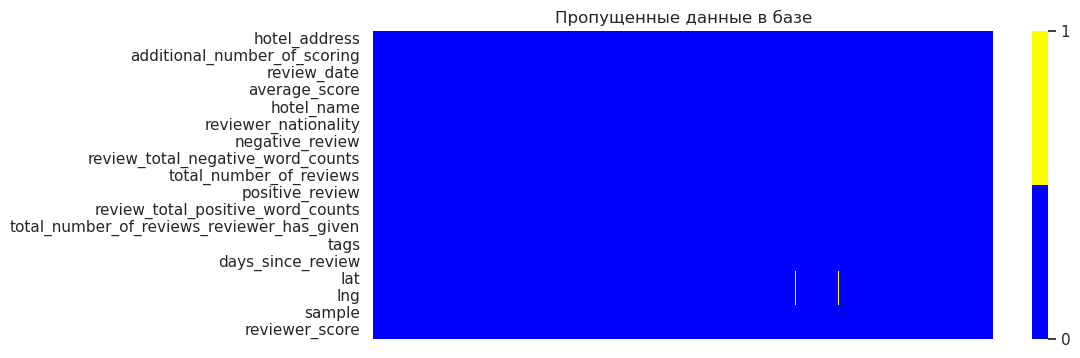

In [5]:
# Строим тепловую карту, где желтым отмечены пропущеные значения
cbar_kws = { 'ticks' : [0,1] }
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    n_hotels.T.isnull(), # Создаем карту пропущенных значений в базе данных
    cmap=sns.color_palette(colors),
    xticklabels=False,
    cbar_kws = cbar_kws
)
ax.set_title('Пропущенные данные в базе');

**Observation:** There missing lat lng for some positions in our data set

## Filling in the gaps in geographic coordinates. (Feature generation)

In [6]:
n_hotels[n_hotels['lat'].isnull()][['hotel_name', 'hotel_address']]


,hotel_name,hotel_address
35,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
293,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
476,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...
526,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France
569,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...
...,...,...
514720,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515093,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515132,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France
515330,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...


In [7]:
n_hotels.iloc[2]['hotel_address']

'Mallorca 251 Eixample 08008 Barcelona Spain'

In [8]:
#==================
#  Get Coordinates
#==================

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
# Initialize geocoder (use descriptive user agent to avoid blocking)
geolocator = Nominatim(user_agent="HotelGeoFinder")

# Add rate limiter to avoid hitting the API too fast
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Helper function to get both coordinates
def get_coordinates(address):
    """Return (latitude, longitude) tuple for a full address using Nominatim."""
    shortaddress = " ".join(address.split()[-3:])
    try:
        if not isinstance(address, str) or address.strip() == "":
            return (np.nan, np.nan)
        
        location = geocode(shortaddress)  # use full address
        if location:
            return (location.latitude, location.longitude)
        else:
            return (np.nan, np.nan)
    except Exception as e:
        print(f"Error geocoding address '{address}': {e}")
        return (np.nan, np.nan)

In [9]:
# Find addresses with missing coordinates
missing_coords = n_hotels[n_hotels['lng'].isnull() | n_hotels['lat'].isnull()]['hotel_address'].unique()
print(f"Found {len(missing_coords)} addresses with missing coordinates.")

# Build a dictionary of {address: (lat, lng)}
coords_dict = {addr: get_coordinates(addr) for addr in missing_coords}

# Map to dataframe
coords_df = n_hotels['hotel_address'].map(coords_dict)

# Split the tuple into two columns
n_hotels['lat'] = n_hotels['lat'].fillna(coords_df.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan))
n_hotels['lng'] = n_hotels['lng'].fillna(coords_df.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan))
n_hotels[n_hotels['lat'].isnull()][['hotel_name', 'hotel_address']]

Found 17 addresses with missing coordinates.


,hotel_name,hotel_address


In [10]:
#==================
#  Hotel Country
#==================

# Extract last word of address as hotel_country
#n_hotels['hotel_country'] = n_hotels['hotel_address'].apply(lambda x: str(x).split()[-1])

known_countries = ['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy']

def extract_hotel_country(address):
    for country in known_countries:
        if country.lower() in address.lower():
            return country
    return 'Unknown'

n_hotels['hotel_country'] = n_hotels['hotel_address'].apply(extract_hotel_country)

In [11]:
#==================
#  Hotel City
#==================

from geopy.distance import geodesic

city_centers = {
    'London': (51.509865, -0.118092),
    'Barcelona': (41.3851, 2.1734),
    'Paris': (48.8566, 2.3522),
    'Amsterdam': (52.3676, 4.9041),
    'Vienna': (48.2082, 16.3738),
    'Milan': (45.4642, 9.19)
}

def extract_city(address):
    """Extract city name from address (based on known city list)."""
    for city in city_centers.keys():
        if city.lower() in address.lower():
            return city
    return 'Unknown'

# Create hotel_city
n_hotels['hotel_city'] = n_hotels['hotel_address'].apply(extract_city)

In [12]:
#==================
#  Hotel Distance from City_center
#==================

def compute_distance(row):
    city = row['hotel_city']
    if city == 'Unknown' or pd.isna(row['lat']) or pd.isna(row['lng']):
        return np.nan
    center_coords = city_centers.get(city)
    hotel_coords = (row['lat'], row['lng'])
    return geodesic(hotel_coords, center_coords).km

n_hotels['distance_from_city_center'] = n_hotels.apply(compute_distance, axis=1)


In [13]:
#==================
#  Hotel Zone
#==================

def zone_from_distance(d):
    if pd.isna(d):
        return np.nan
    elif d < 2:
        return 1  # City center
    elif d < 5:
        return 2  # Near center
    else:
        return 3  # Far from center

n_hotels['distance_zone'] = n_hotels['distance_from_city_center'].apply(zone_from_distance)


In [14]:
#==================
#  Domestic Ttravel
#==================

n_hotels['domestic_traveler_flag'] = (
    n_hotels['hotel_country'].str.strip().str.lower() ==
    n_hotels['reviewer_nationality'].str.strip().str.lower()
).astype(int)

print(n_hotels['domestic_traveler_flag'].value_counts())


0    337047
1    178384
Name: domestic_traveler_flag, dtype: int64


In [15]:
#==================
#  Cross Continent Travel
#==================

continent_map = {
    'europe': ['united kingdom', 'france', 'germany', 'spain', 'italy', 'netherlands', 'belgium', 'sweden', 'norway', 'switzerland', 'portugal', 'poland', 'austria', 'greece', 'ireland', 'finland', 'czech republic', 'denmark', 'hungary', 'slovakia', 'romania', 'bulgaria', 'croatia', 'slovenia', 'iceland'],
    'asia': ['china', 'india', 'japan', 'malaysia', 'singapore', 'thailand', 'south korea', 'indonesia', 'philippines', 'vietnam', 'pakistan', 'bangladesh'],
    'americas': ['united states of america', 'canada', 'mexico', 'brazil', 'argentina', 'chile', 'colombia', 'peru'],
    'middle_east': ['united arab emirates', 'saudi arabia', 'qatar', 'kuwait', 'bahrain', 'oman', 'lebanon'],
    'africa': ['south africa', 'morocco', 'egypt', 'kenya', 'nigeria', 'ghana'],
    'oceania': ['australia', 'new zealand']
}

def get_continent(country):
    if pd.isna(country) or country.strip() == '':
        return 'unknown'
    country = country.strip().lower()
    for cont, countries in continent_map.items():
        if country in countries:
            return cont
    return 'other'

n_hotels['hotel_continent'] = n_hotels['hotel_country'].apply(get_continent)
n_hotels['reviewer_continent'] = n_hotels['reviewer_nationality'].apply(get_continent)

n_hotels['cross_region_flag'] = (
    (n_hotels['hotel_continent'] != n_hotels['reviewer_continent']).astype(int)
)

print(n_hotels[['hotel_country', 'reviewer_nationality', 'domestic_traveler_flag']].sample(10))
print(n_hotels['cross_region_flag'].value_counts(normalize=True))

         hotel_country reviewer_nationality  domestic_traveler_flag
217810     Netherlands      United Kingdom                        0
233457     Netherlands      United Kingdom                        0
44408   United Kingdom      United Kingdom                        1
454151         Austria              Israel                        0
507662           Italy               China                        0
97406            Spain              Canada                        0
133104  United Kingdom      United Kingdom                        1
479553           Italy             Austria                        0
364910  United Kingdom              Kuwait                        0
36230          Austria      United Kingdom                        0
0    0.666768
1    0.333232
Name: cross_region_flag, dtype: float64


Local visitors often have different expectations → tend to rate differently.

Far travelers might visit more expensive or tourist-oriented hotels → correlation with higher/lower reviewer_score.

It also serves as a proxy for tourism type or international popularity.

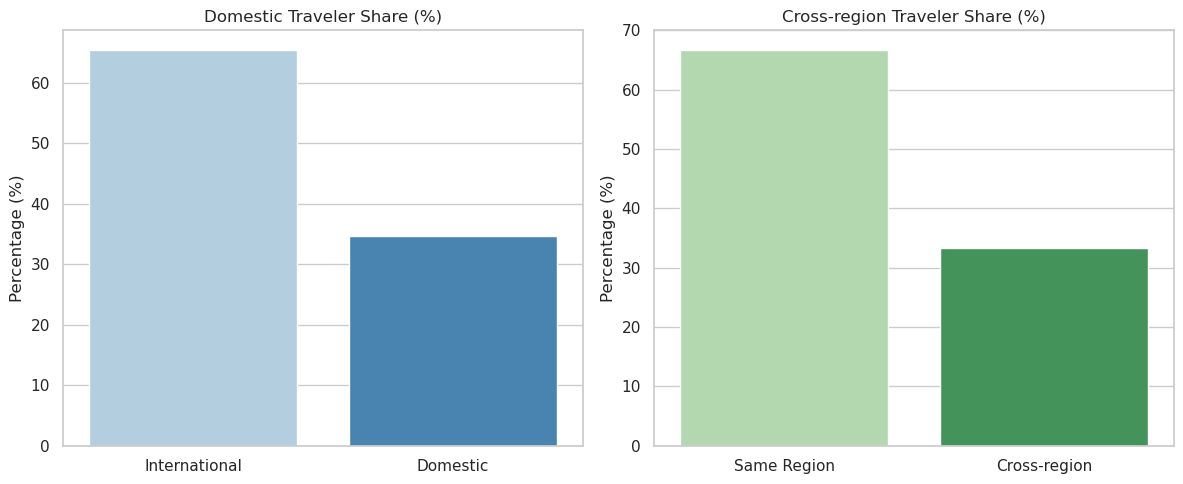

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot domestic vs international (cross-region)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Domestic traveler share
domestic_counts = n_hotels['domestic_traveler_flag'].value_counts(normalize=True) * 100
sns.barplot(
    x=domestic_counts.index,
    y=domestic_counts.values,
    ax=ax[0],
    palette='Blues'
)
ax[0].set_title("Domestic Traveler Share (%)")
ax[0].set_xticklabels(['International', 'Domestic'])
ax[0].set_ylabel("Percentage (%)")

# Cross-region share
cross_counts = n_hotels['cross_region_flag'].value_counts(normalize=True) * 100
sns.barplot(
    x=cross_counts.index,
    y=cross_counts.values,
    ax=ax[1],
    palette='Greens'
)
ax[1].set_title("Cross-region Traveler Share (%)")
ax[1].set_xticklabels(['Same Region', 'Cross-region'])
ax[1].set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show()



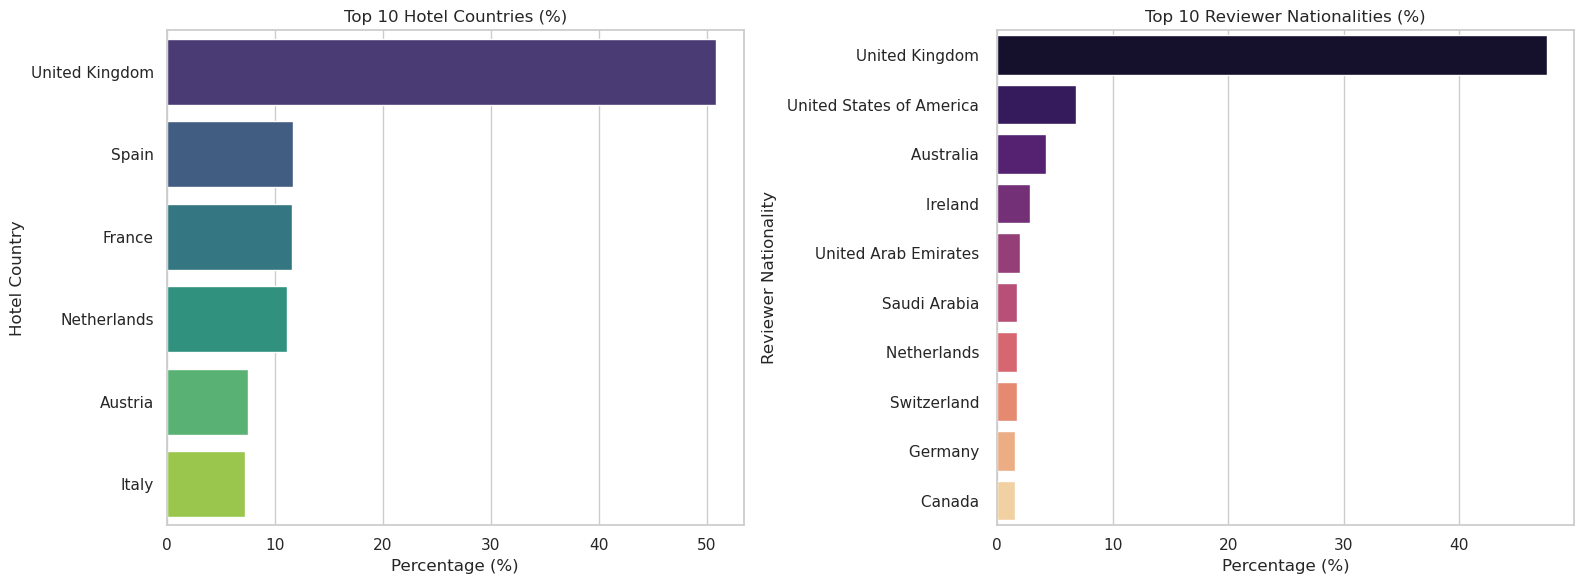

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Top hotel countries
top_hotels = n_hotels['hotel_country'].value_counts(normalize=True).head(10) * 100
sns.barplot(
    y=top_hotels.index,
    x=top_hotels.values,
    ax=ax[0],
    palette='viridis'
)
ax[0].set_title("Top 10 Hotel Countries (%)")
ax[0].set_xlabel("Percentage (%)")
ax[0].set_ylabel("Hotel Country")

# Top reviewer nationalities
top_reviewers = n_hotels['reviewer_nationality'].value_counts(normalize=True).head(10) * 100
sns.barplot(
    y=top_reviewers.index,
    x=top_reviewers.values,
    ax=ax[1],
    palette='magma'
)
ax[1].set_title("Top 10 Reviewer Nationalities (%)")
ax[1].set_xlabel("Percentage (%)")
ax[1].set_ylabel("Reviewer Nationality")

plt.tight_layout()
plt.show()


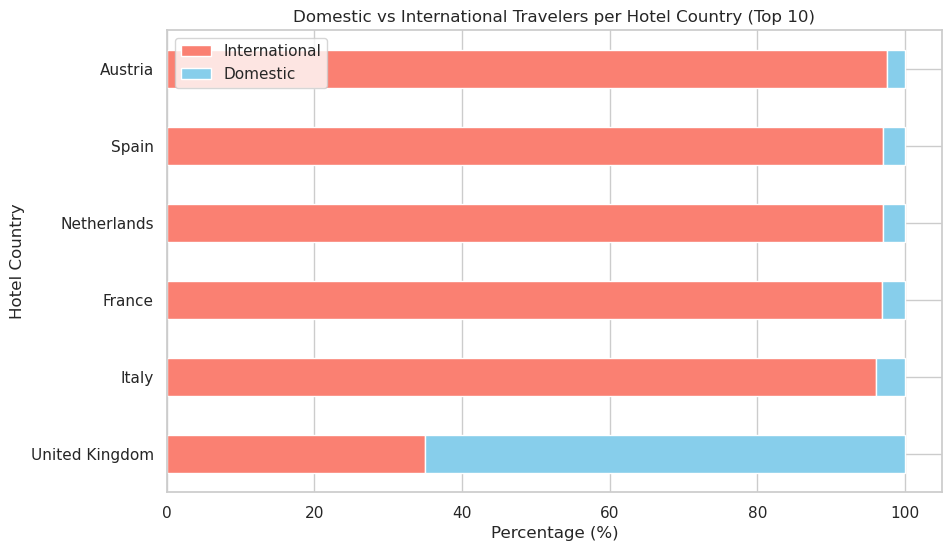

In [18]:
# Group by hotel_country and domestic flag
domestic_by_country = (
    n_hotels.groupby(['hotel_country', 'domestic_traveler_flag'])
    .size()
    .unstack(fill_value=0)
)

# Convert to percentages
domestic_by_country = domestic_by_country.div(domestic_by_country.sum(axis=1), axis=0) * 100

# Plot
domestic_by_country.sort_values(1, ascending=False).head(10).plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=['salmon', 'skyblue']
)
plt.title("Domestic vs International Travelers per Hotel Country (Top 10)")
plt.xlabel("Percentage (%)")
plt.ylabel("Hotel Country")
plt.legend(['International', 'Domestic'])
plt.show()


In [19]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [20]:
nn_hotels = n_hotels.copy()

## Tag Processing

In [21]:
'''
# ============================================
# TAGS PREPROCESSING
# ============================================

# Convert the string representation of tags to a list
def parse_tags(tag_str):
    """Convert tag string to list of individual tags"""
    if pd.isnull(tag_str):
        return []
    tag_str = tag_str[2:-2]  # remove the leading/trailing brackets
    return tag_str.strip().split("', '")

n_hotels['tags_n'] = n_hotels['tags'].apply(parse_tags)

# Explode the lists to analyze tag frequencies
explode = n_hotels.explode('tags_n')

# Count frequency of each tag
tag_counts = explode['tags_n'].value_counts()

# Select only popular tags (appearing more than 900 times)
popular_tags = tag_counts[tag_counts > 900].index.tolist()

print(f"Total unique tags: {explode['tags_n'].nunique()}")
print(f"Selected top frequent tags: {len(popular_tags)}")

# --------------------------------------------
# Efficient binary encoding of top tags
# --------------------------------------------
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=popular_tags)
tags_encoded = pd.DataFrame(
    mlb.fit_transform(n_hotels['tags_n']),
    columns=mlb.classes_,
    index=n_hotels.index
)

# Merge the encoded tags into the main dataframe
n_hotels = pd.concat([n_hotels, tags_encoded], axis=1)

# Optional: drop the original columns if not needed
n_hotels = n_hotels.drop(['tags', 'tags_n'], axis=1)

# Check the new dataframe
n_hotels.head(3)
'''

'\n# ============================================\n# TAGS PREPROCESSING\n# ============================================\n\n# Convert the string representation of tags to a list\ndef parse_tags(tag_str):\n    """Convert tag string to list of individual tags"""\n    if pd.isnull(tag_str):\n        return []\n    tag_str = tag_str[2:-2]  # remove the leading/trailing brackets\n    return tag_str.strip().split("\', \'")\n\nn_hotels[\'tags_n\'] = n_hotels[\'tags\'].apply(parse_tags)\n\n# Explode the lists to analyze tag frequencies\nexplode = n_hotels.explode(\'tags_n\')\n\n# Count frequency of each tag\ntag_counts = explode[\'tags_n\'].value_counts()\n\n# Select only popular tags (appearing more than 900 times)\npopular_tags = tag_counts[tag_counts > 900].index.tolist()\n\nprint(f"Total unique tags: {explode[\'tags_n\'].nunique()}")\nprint(f"Selected top frequent tags: {len(popular_tags)}")\n\n# --------------------------------------------\n# Efficient binary encoding of top tags\n# ------

In [22]:
n_hotels = nn_hotels.copy()

In [23]:
n_hotels['tags'].apply(lambda x: x.split(',')[0].strip()).unique()

array(["[' Leisure trip '", "[' Business trip '", "[' Group '",
       "[' Couple '", "[' With a pet '",
       "[' Family with young children '", "[' Solo traveler '",
       "[' Family with older children '", "[' Group ']",
       "[' Travelers with friends '", "[' Couple ']",
       "[' Family with young children ']"], dtype=object)

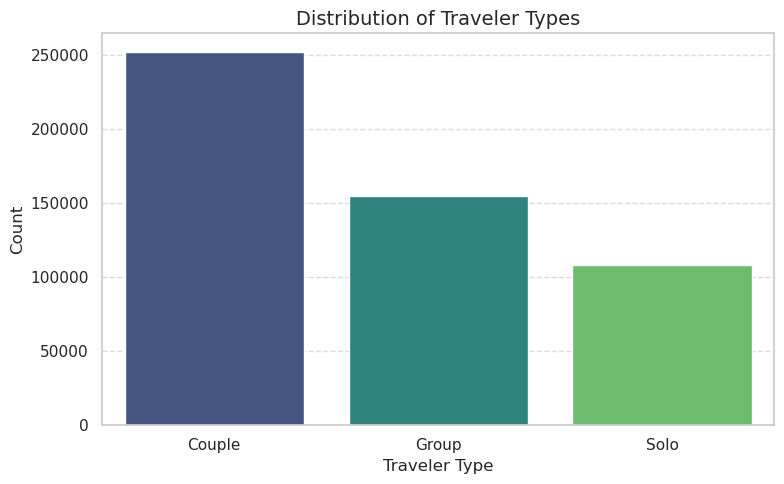

In [24]:

# -------------------------------
#  Trip type
# -------------------------------
# Extract trip type tags, e.g., "Leisure trip", "Business trip"
#regex_trip = r"(Leisure trip|Business trip|.*? trip)"
#n_hotels['trip'] = n_hotels['tags'].str.extract(regex_trip)
# Encode trip type as ordinal
#trip_encoder = ce.OrdinalEncoder()
#n_hotels['trip'] = trip_encoder.fit_transform(n_hotels[['trip']])
# Remove trip tags from 'tags' column
#n_hotels['tags'] = n_hotels['tags'].str.replace(regex_trip, '', regex=True)


# -------------------------------
#  Simplified Traveler type
# -------------------------------

def categorize_traveler(tag_str):
    """
    Categorize traveler type based on keywords anywhere in the tag string.
    Returns:
      1 = solo
      2 = couple
      3 = group/family/friends
      0 = unknown
    """
    if pd.isna(tag_str) or not isinstance(tag_str, str) or tag_str.strip() == '':
        return 0

    tag_lower = tag_str.lower()

    if "solo" in tag_lower:
        return 1
    elif "couple" in tag_lower:
        return 2
    elif any(word in tag_lower for word in ["group", "children", "friends"]):
        return 3
    else:
        return 0


# Apply the function
n_hotels['traveler_type'] = n_hotels['tags'].apply(categorize_traveler)
'''
# Show distribution
traveler_type_counts = n_hotels['traveler_type'].value_counts().sort_index().reset_index()
traveler_type_counts.columns = ['Traveler_Type', 'Count']
print("Simplified traveler types:")
print(traveler_type_counts)

'''

# Remove traveler_type tag from 'tags' column (optional cleanup)
traveler_type_original = ['Couple','Solo traveler','Family with young children','Group','Family with older children','Travelers with friends']
for key in traveler_type_original: #traveler_type_counts['Traveler_Type'].unique():
    n_hotels['tags'] = n_hotels['tags'].str.replace(str(key), '', regex=False)




# Optional: map numeric codes to readable labels
traveler_labels = {
    0: 'Unknown',
    1: 'Solo',
    2: 'Couple',
    3: 'Group'
}

# Create a labeled Series for plotting
traveler_counts = n_hotels['traveler_type'].map(traveler_labels).value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=traveler_counts.index, y=traveler_counts.values, palette='viridis')
plt.title('Distribution of Traveler Types', fontsize=14)
plt.xlabel('Traveler Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# ============================================
# TAGS CLEANING AND FEATURE EXTRACTION
# ============================================

#from collections import Counter
#import category_encoders as ce


# -------------------------------
#  Extract number of nights stayed
# -------------------------------
#import re

# Extract the number of nights from tags, e.g., "Stayed 3 nights"
regex_nights = r'Stayed (\d+) night[s]?'
n_hotels['nights'] = n_hotels['tags'].str.extract(regex_nights)
n_hotels['nights'] = n_hotels['nights'].fillna(0).astype(int)

# Remove nights-related tags from the 'tags' column
n_hotels['tags'] = n_hotels['tags'].str.replace(regex_nights, '', regex=True)

In [26]:
n_hotels['tags'][2]

"[' Business trip ', '  ', ' Twin Room ', '  ', ' Submitted from a mobile device ']"

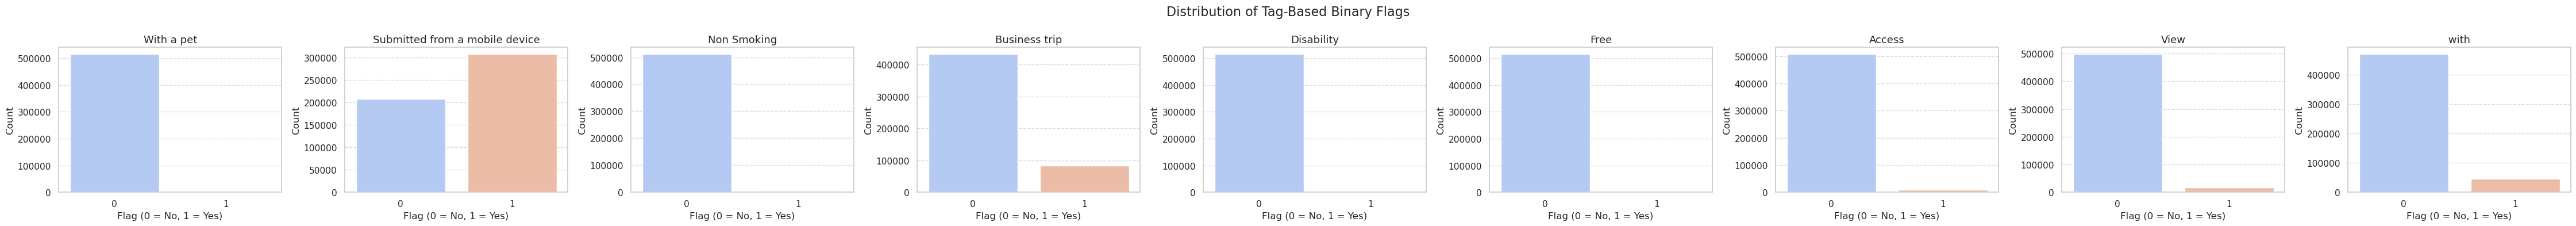

In [27]:
# -------------------------------
#  Extracttag feature
# -------------------------------

# Dictionary of tag-based binary features
tag_features = {
    'pet_flag': 'With a pet',
    'mobile_flag': 'Submitted from a mobile device',
    'non_smoking_flag': 'Non Smoking',
    'business_trip_flag': 'Business trip',
    'disability_flag': 'Disability',
    'free_flag': 'Free',
    'access_flag': 'Access',
    'view_flag': 'View',
    'supply_flag': ' with '
}

#  Generate flag columns and clean tags 
for flag, keyword in tag_features.items():
    n_hotels[flag] = n_hotels['tags'].str.contains(keyword, case=False, regex=False).astype(int)
    n_hotels['tags'] = n_hotels['tags'].str.replace(keyword, '', regex=False)

#  Plot the distributions 
num_flags = len(tag_features)
fig, axes = plt.subplots(1, num_flags, figsize=(5*num_flags, 4))

if num_flags == 1:
    axes = [axes]  # Ensure iterable if only one plot

for ax, (flag, label) in zip(axes, tag_features.items()):
    counts = n_hotels[flag].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='coolwarm')
    ax.set_title(f"{label}", fontsize=13)
    ax.set_xlabel('Flag (0 = No, 1 = Yes)')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Distribution of Tag-Based Binary Flags", fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
# Create a flag for rooms with balcon
n_hotels['balcony_flag'] = (
    n_hotels['tags']
    .str.contains(r'balcony|terrase|garden', case=False, na=False) #"with" got removed, so "out" 
    .astype(int)
)
n_hotels['tags'] = n_hotels['tags'].str.replace(r'balcony|terrace|garden', '', case=False, regex=True)

# Create a flag for rooms without windows
n_hotels['no_window_flag'] = (
    n_hotels['tags']
    .str.contains(r'without window|no window', case=False, na=False) 
    .astype(int)
)
n_hotels['tags'] = n_hotels['tags'].str.replace(r'without window|no window', '', case=False, regex=True)

n_hotels['no_window_flag'].sum()

3013

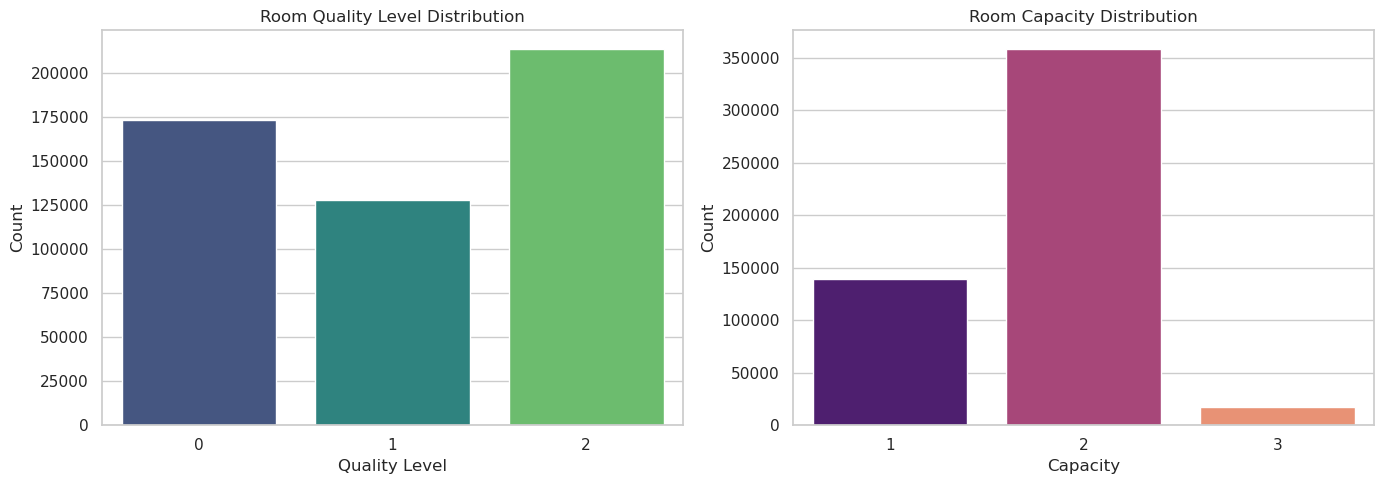

In [29]:
# ============================================
# ROOM FEATURES EXTRACTION
# ============================================


# -------------------------------
#   Split 'tags' into 'room' and 'supplies'
# -------------------------------
#def extract_room_supplies(tag_str):
#    """Split tag string by 'with': room type vs extra supplies/view"""
#    parts = tag_str.split('with')
#    if len(parts) == 1:
#        return parts[0].strip(), None
#    else:
#        return parts[0].strip(), parts[1].replace('view', 'View').strip()
#n_hotels['room'], n_hotels['supplies'] = zip(*n_hotels['tags'].apply(extract_room_supplies))

# -------------------------------
#   Room type (Single, Double/Twin, Triple, Studio, Suite)
# -------------------------------

def get_room_capacity(tag):
    tag = str(tag).lower()
    if "single" in tag or "studio" in tag or "suite" in tag:
        return 1
    elif "double" in tag or "twin" in tag or "2 rooms" in tag:
        return 2
    elif "triple" in tag or "3 rooms" in tag:
        return 3
    elif "quadruple" in tag or "family" in tag:
        return 3
    else:
        return 1

n_hotels['room_capacity'] = n_hotels['tags'].apply(get_room_capacity)



# -------------------------------
#   Room description (Standard, Family, Queen, King, Luxury, Deluxe, Executive, Superior)
# -------------------------------
quality_tag_1 = ['standard', 'basic', 'economy', 'ordinary', 'classic']
quality_tag_2 = ['queen', 'king', 'superior', 'deluxe', 'executive', 'club', 'premium','premier', 'luxury']
def get_room_quality(tag):
    tag = str(tag).lower()
    if any(word in tag for word in quality_tag_1):
        return 1
    elif any(word in tag for word in quality_tag_2):
        return 2
    else:
        return 0

n_hotels['room_quality_level'] = n_hotels['tags'].apply(get_room_quality)


fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=n_hotels, x='room_quality_level', ax=axes[0], palette='viridis')
axes[0].set_title("Room Quality Level Distribution")
axes[0].set_xlabel("Quality Level")
axes[0].set_ylabel("Count")

sns.countplot(data=n_hotels, x='room_capacity', ax=axes[1], palette='magma')
axes[1].set_title("Room Capacity Distribution")
axes[1].set_xlabel("Capacity")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()



In [30]:
# -------------------------------
#  Clean leftover tags string
# -------------------------------
import re

# Remove traveler_type tag from 'tags' column (optional cleanup)
remove_tag = ["leisure trip", "business trip", "single", "studio", "suite", "double","twin" , "2 rooms","triple","3 rooms" ,"quadruple"] + quality_tag_1 + quality_tag_2

for key in remove_tag:
    # (?i) makes the pattern case-insensitive
    pattern = rf"(?i){re.escape(key)}"
    n_hotels['tags'] = n_hotels['tags'].str.replace(pattern, '', regex=True)

n_hotels['tags'] = n_hotels['tags'].str.replace('[\[\]\'\,]', '', regex=True)
n_hotels['tags'] = n_hotels['tags'].str.strip()

### 1. Clean and Split Tags Properly

Each tag string might contain multiple supplies separated by spaces, commas, or multiple spaces.
Let’s normalize that first.

In [31]:
'''
import pandas as pd
from collections import Counter


# Example: ensure the column is treated as string and handle NaNs
n_hotels['tags'] = n_hotels['tags'].astype(str).fillna('')

# Split tags — this version is robust against multiple spaces or commas
def split_tags(tag_string):
    # Remove quotes and "None"
    tag_string = tag_string.strip().replace("None", "").strip("'\"")
    if not tag_string:
        return []
    # Split by 2+ spaces, commas, or semicolons
    items = re.split(r'\s{2,}|,|;', tag_string)
    # Strip whitespace around each tag and remove empties
    return [item.strip() for item in items if item.strip()]

# Apply to all rows
n_hotels['tag_list'] = n_hotels['tags'].apply(split_tags)
# Flatten list of lists into a single list of tags
all_tags = [tag for tags in n_hotels['tag_list'] for tag in tags]

# Count frequency
supplies_counter = Counter(all_tags)

# Show number of unique tags and top 20
print(f"Number of unique supplies: {len(supplies_counter)}")
#print(supplies_counter.most_common(120))

#  Get popular supplies
popular_supplies = [k for k, v in supplies_counter.items() if v > 500]
print(f"Popular supplies (occurrences > 500): {len(popular_supplies)}")
print(popular_supplies)


import matplotlib.pyplot as plt

# Convert to DataFrame for plotting
supplies_df = pd.DataFrame(supplies_counter.most_common(60), columns=['Supply', 'Count'])

plt.figure(figsize=(10,22))
plt.barh(supplies_df['Supply'], supplies_df['Count'])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Common Hotel Tags")
plt.xlabel("Count")
plt.show()

'''

'\nimport pandas as pd\nfrom collections import Counter\n\n\n# Example: ensure the column is treated as string and handle NaNs\nn_hotels[\'tags\'] = n_hotels[\'tags\'].astype(str).fillna(\'\')\n\n# Split tags — this version is robust against multiple spaces or commas\ndef split_tags(tag_string):\n    # Remove quotes and "None"\n    tag_string = tag_string.strip().replace("None", "").strip("\'"")\n    if not tag_string:\n        return []\n    # Split by 2+ spaces, commas, or semicolons\n    items = re.split(r\'\\s{2,}|,|;\', tag_string)\n    # Strip whitespace around each tag and remove empties\n    return [item.strip() for item in items if item.strip()]\n\n# Apply to all rows\nn_hotels[\'tag_list\'] = n_hotels[\'tags\'].apply(split_tags)\n# Flatten list of lists into a single list of tags\nall_tags = [tag for tags in n_hotels[\'tag_list\'] for tag in tags]\n\n# Count frequency\nsupplies_counter = Counter(all_tags)\n\n# Show number of unique tags and top 20\nprint(f"Number of unique su

In [32]:
# ==========================================
#  Long stay flag
# ==========================================
n_hotels['long_stay_flag'] = (n_hotels['nights'] > 5).astype(int)



# ==========================================
#  Reviewer experience (log transform)
# ==========================================
n_hotels['reviewer_experience'] = np.log1p(
    n_hotels['total_number_of_reviews_reviewer_has_given']
)

## Encoding of Reviews

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


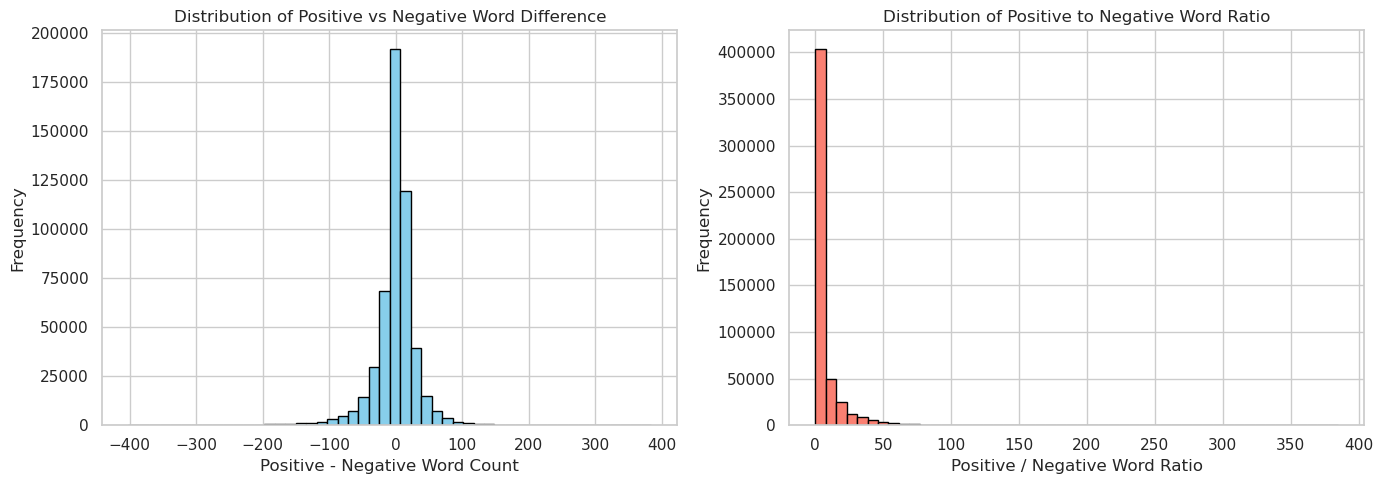

In [33]:
# ============================================
# SENTIMENT ENCODING OF REVIEWS
# ============================================

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Function to compute the compound sentiment score
def get_compound_score(text):
    """Return the VADER compound sentiment score for a given text."""
    return sent_analyzer.polarity_scores(text)['compound']

# Apply sentiment analysis to positive and negative reviews
n_hotels['positive_score'] = n_hotels['positive_review'].apply(get_compound_score)
n_hotels['negative_score'] = n_hotels['negative_review'].apply(get_compound_score)

# Drop the original text columns as they are now encoded
n_hotels.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

#=========
# Create a new feature for the difference between positive and negative word counts
n_hotels['pos_vs_neg_words'] = (
    n_hotels['review_total_positive_word_counts'] - n_hotels['review_total_negative_word_counts']
)

# Optional: explore the distribution
#print(n_hotels['pos_vs_neg_words'].describe())



#========
# Create a new feature for the ratio between positive and negative word counts
n_hotels['pos_to_neg_ratio'] = (
    (n_hotels['review_total_positive_word_counts'] + 1) /
    (n_hotels['review_total_negative_word_counts'] + 1)
)

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left plot: difference ---
axes[0].hist(n_hotels['pos_vs_neg_words'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Positive vs Negative Word Difference')
axes[0].set_xlabel('Positive - Negative Word Count')
axes[0].set_ylabel('Frequency')

# --- Right plot: ratio ---
axes[1].hist(n_hotels['pos_to_neg_ratio'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Positive to Negative Word Ratio')
axes[1].set_xlabel('Positive / Negative Word Ratio')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Date-Based Features

In [34]:

# =====================================================
#  Transform Days Since Review
# =====================================================

# Convert review date to datetime format
# Remove non-digit characters and convert to int
# Convert all values to string, extract digits, then convert to int
n_hotels['days_since_review'] = (
    n_hotels['days_since_review']
    .astype(str)                 # ensure all values are strings
    .str.extract(r'(\d+)')       # extract numeric part
    .astype(int)                 # convert to integer
)

# ==========================================
#  Recency weight
# ==========================================
n_hotels['recency_weight'] = 1 / np.log1p( n_hotels['days_since_review'] + 1 )



#  Ensure review_date is a datetime object
n_hotels['review_date'] = pd.to_datetime(n_hotels['review_date'], errors='coerce')


# Calculate travel date
n_hotels['travel_date'] = n_hotels['review_date'] - pd.to_timedelta(n_hotels['days_since_review'], unit='D')

# Optional: extract year/month/season for analysis
n_hotels['travel_year'] = n_hotels['travel_date'].dt.year
n_hotels['travel_month'] = n_hotels['travel_date'].dt.month


In [35]:
pd.to_timedelta(n_hotels['days_since_review'], unit='D')

0         13 days
1        234 days
2        616 days
3        656 days
4        444 days
           ...   
515426   106 days
515427   171 days
515428   543 days
515429    74 days
515430   363 days
Name: days_since_review, Length: 515431, dtype: timedelta64[ns]

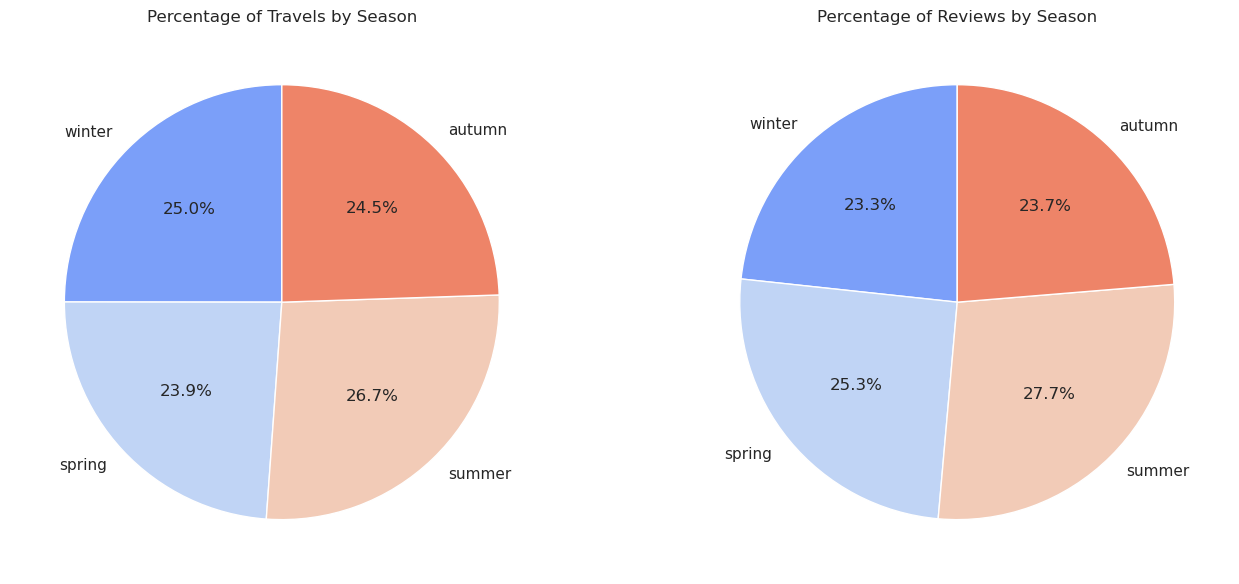

In [36]:

def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'
# Create the 'season' column from travel_date
n_hotels['season'] = n_hotels['review_date'].apply(get_season)


import matplotlib.pyplot as plt
import seaborn as sns

# Apply your function to both date columns
travel_season = n_hotels['travel_date'].apply(get_season)
review_season = n_hotels['review_date'].apply(get_season)

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Common color palette (consistent across both)
palette = sns.color_palette('coolwarm', 4)
season_order = ['winter', 'spring', 'summer', 'autumn']

# Left: Travel date season pie chart
travel_season.value_counts()[season_order].plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=palette,
    ax=axes[0]
)
axes[0].set_title('Percentage of Travels by Season')
axes[0].set_ylabel('')

# Right: Review date season pie chart
review_season.value_counts()[season_order].plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=palette,
    ax=axes[1]
)
axes[1].set_title('Percentage of Reviews by Season')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# ==========================================
#  Season encoded (cyclical transformation)
# sin/cos encoding helps models understand seasonality
# ==========================================
#season_map = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}
#n_hotels['season_num'] = n_hotels['season'].str.lower().map(season_map)

#n_hotels['season_sin'] = np.sin(2 * np.pi * n_hotels['season_num'] / 4)
#n_hotels['season_cos'] = np.cos(2 * np.pi * n_hotels['season_num'] / 4)

In [37]:

# One-hot encode the 'season' column
season_dummies = pd.get_dummies(n_hotels['season'], prefix='season')
season_dummies = season_dummies.add_suffix('_flag')

# Join encoded columns back to the dataset
n_hotels = pd.concat([n_hotels, season_dummies], axis=1)

# Drop the original 'season' column
#n_hotels.drop('season', axis=1, inplace=True)

# Check result
n_hotels.head()
''''''

''

In [38]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   review_total_negative_word_counts           515431 non-null  int64         
 7   total_number_of_reviews                     515431 non-null  int64         
 8   review_total_positive_word_counts           515431 non-null  int64        

In [39]:
# Keep only numeric columns
#n_hotels_numeric = n_hotels.select_dtypes(include=['number']).copy()

# Check resulting columns
#print(n_hotels_numeric.columns)

#n_hotels = n_hotels.select_dtypes(include=['number'])

## More features!

In [40]:
#  Review density / proportion features

n_hotels['review_density'] = (
    n_hotels['total_number_of_reviews'] / 
    (n_hotels['total_number_of_reviews'] + n_hotels['additional_number_of_scoring'] + 1)
)


In [41]:
#  Total feedback volume

n_hotels['total_feedback_count'] = (
    n_hotels['total_number_of_reviews'] + n_hotels['additional_number_of_scoring']
)

In [42]:
#  Weighted average of individual reviewer score and global score

n_hotels['score_difference'] = (
    n_hotels['reviewer_score'] - n_hotels['average_score']
)

n_hotels['score_deviation'] = n_hotels['score_difference'].abs()

n_hotels['popularity_index'] = (
    n_hotels['average_score'] * np.log1p(n_hotels['total_feedback_count'])
)

In [43]:
#  Engagement gap

n_hotels['rating_only_ratio'] = (
    n_hotels['additional_number_of_scoring'] /
    (n_hotels['total_number_of_reviews'] + n_hotels['additional_number_of_scoring'] + 1)
)


In [44]:
#  Score normalization by popularity

n_hotels['adjusted_score'] = (
    n_hotels['average_score'] * 
    (1 - np.exp(-n_hotels['total_feedback_count'] / 500))
)

#  Reviewer bias index

n_hotels['reviewer_bias'] = (
    n_hotels['reviewer_score'] - n_hotels['average_score']
)


In [45]:
# Weighted average influence

n_hotels['avg_score_times_total_reviews'] = n_hotels['average_score'] * n_hotels['total_number_of_reviews']
n_hotels['avg_score_times_additional_scoring'] = n_hotels['average_score'] * n_hotels['additional_number_of_scoring']

# ratio
n_hotels['positive_to_negative_ratio'] = (n_hotels['review_total_positive_word_counts'] + 1) / \
                                        (n_hotels['review_total_negative_word_counts'] + 1)

In [46]:
nn_hotels = n_hotels.copy()

# Exploratory data analysis (EDA)
Before feeding our cleaned dataset into a machine learning model, it’s crucial to analyze it and understand the distributions, potential outliers, and correlations. This step helps avoid garbage-in, garbage-out scenarios.

In [47]:
# Check missing values
missing = n_hotels.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)

object_cols = n_hotels.select_dtypes(include='object')
print(f"Number of object columns: {object_cols.shape[1]}")
print(object_cols.columns.tolist())

#n_hotels = n_hotels.drop(columns=n_hotels.select_dtypes(include=['object', 'datetime64[ns]']).columns)

Columns with missing values:
 Series([], dtype: int64)
Number of object columns: 9
['hotel_address', 'hotel_name', 'reviewer_nationality', 'tags', 'hotel_country', 'hotel_city', 'hotel_continent', 'reviewer_continent', 'season']


In [48]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 65 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   review_total_negative_word_counts           515431 non-null  int64         
 7   total_number_of_reviews                     515431 non-null  int64         
 8   review_total_positive_word_counts           515431 non-null  int64        

## Basic statistics

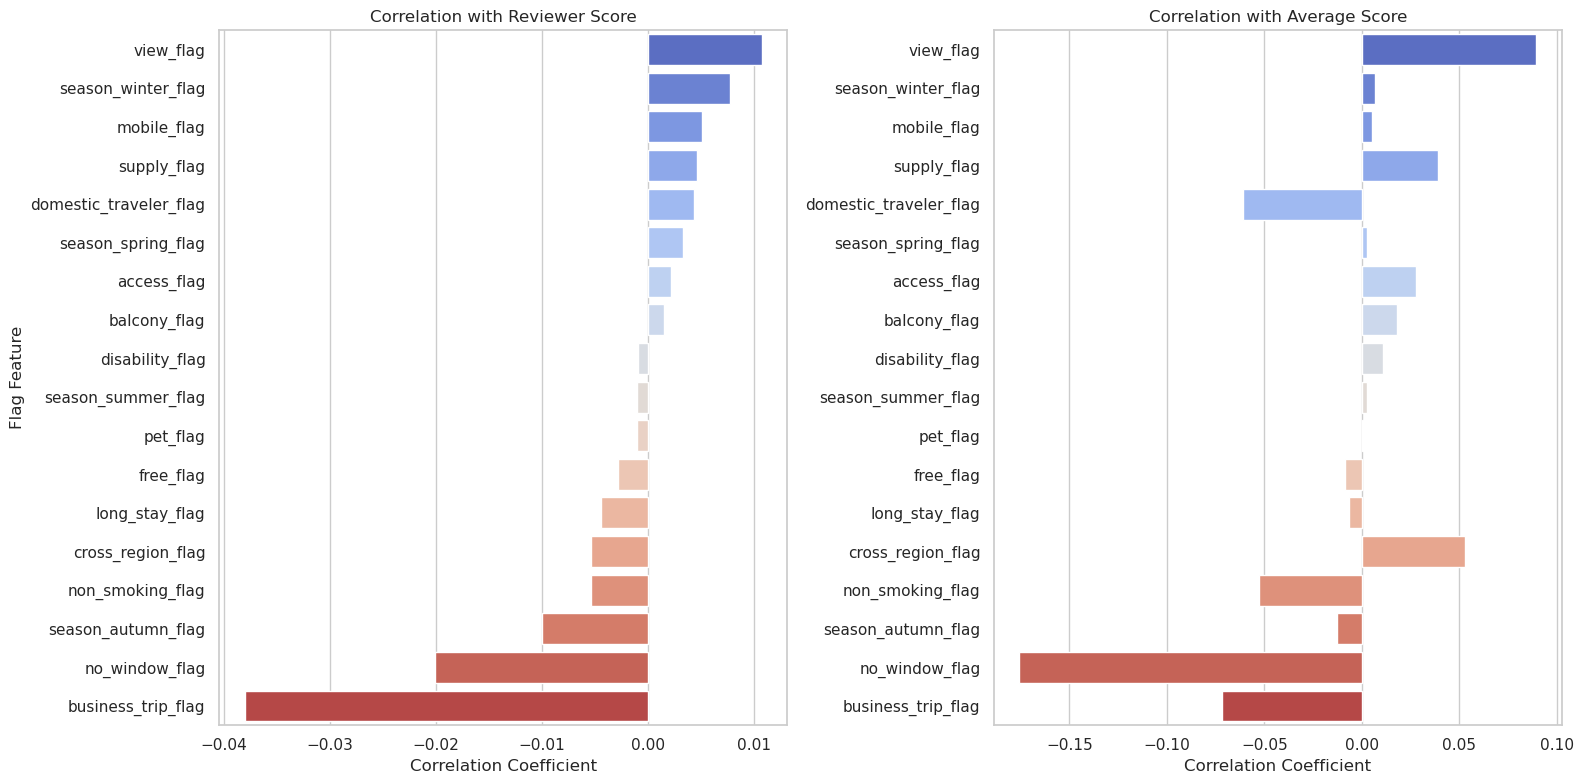

,Corr_with_ReviewerScore,Corr_with_AverageScore
view_flag,0.010699,0.089486
season_winter_flag,0.007719,0.006870
mobile_flag,0.005117,0.004943
supply_flag,0.004659,0.038830
domestic_traveler_flag,0.004287,-0.060702
season_spring_flag,0.003278,0.002778
access_flag,0.002126,0.027756
balcony_flag,0.001482,0.018113
disability_flag,-0.000937,0.010817
season_summer_flag,-0.001004,0.002861


In [49]:
# =====================================================
#  Step: Correlation Between Flag Features and Ratings
# =====================================================

# Automatically select all columns that end with "_flag"
flag_cols = [col for col in n_hotels.columns if col.endswith('_flag')]

# Create a DataFrame containing only flags and target columns
flag_data = n_hotels[flag_cols + ['reviewer_score', 'average_score']]

# Compute the correlation matrix
corr_matrix = flag_data.corr(numeric_only=True)

# Extract correlations of flags with reviewer_score and average_score
corr_with_reviewer = corr_matrix['reviewer_score'].sort_values(ascending=False)
corr_with_average = corr_matrix['average_score'].sort_values(ascending=False)

# Combine into one DataFrame for better comparison
flag_corr = pd.DataFrame({
    'Corr_with_ReviewerScore': corr_with_reviewer[flag_cols],
    'Corr_with_AverageScore': corr_with_average[flag_cols]
}).sort_values(by='Corr_with_ReviewerScore', ascending=False)

#display(flag_corr)

# =====================================================
#  Visualization: Flag Correlation with Ratings
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Reviewer Score
sns.barplot(
    x='Corr_with_ReviewerScore',
    y=flag_corr.index,
    data=flag_corr,
    palette='coolwarm',
    ax=axes[0]
)
axes[0].set_title('Correlation with Reviewer Score')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_ylabel('Flag Feature')

# Average Score
sns.barplot(
    x='Corr_with_AverageScore',
    y=flag_corr.index,
    data=flag_corr,
    palette='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Correlation with Average Score')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_ylabel('')  # No need to repeat label

plt.tight_layout()
plt.show()

display(flag_corr)

In [50]:
# Summary statistics for numerical columns
print(n_hotels.describe().T)

                                               count          mean  \
additional_number_of_scoring                515431.0    498.275079   
average_score                               515431.0      8.397630   
review_total_negative_word_counts           515431.0     18.539760   
total_number_of_reviews                     515431.0   2744.259084   
review_total_positive_word_counts           515431.0     17.777342   
total_number_of_reviews_reviewer_has_given  515431.0      7.165215   
days_since_review                           515431.0    354.405492   
lat                                         515431.0     49.432745   
lng                                         515431.0      2.893820   
sample                                      515431.0      0.749850   
reviewer_score                              515431.0      6.296715   
distance_from_city_center                   515431.0      3.245166   
distance_zone                               515431.0      1.814398   
domestic_traveler_fl

- Some flags are very rare (pet_flag, disability_flag, no_window_flag) → consider grouping or ignoring if analyzing correlation.

- Most reviewers stay 1–2 nights, so nights can be treated as categorical or ordinal.

- pos_to_neg_ratio has very high max (385) → might need log transform for visualization.

##  Log-transform skewed numerical features

In [51]:
n_hotels['pos_to_neg_ratio_log'] = np.log1p( n_hotels['pos_to_neg_ratio'] )

In [52]:
#skewed_cols = ['days_since_review', 'total_number_of_reviews', 'additional_number_of_scoring']

#for col in skewed_cols:
#    n_hotels[col + '_log'] = np.log1p(n_hotels[col])  # log(1+x) to handle zeros

# Visualize distributions of numerical features

In [53]:
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()


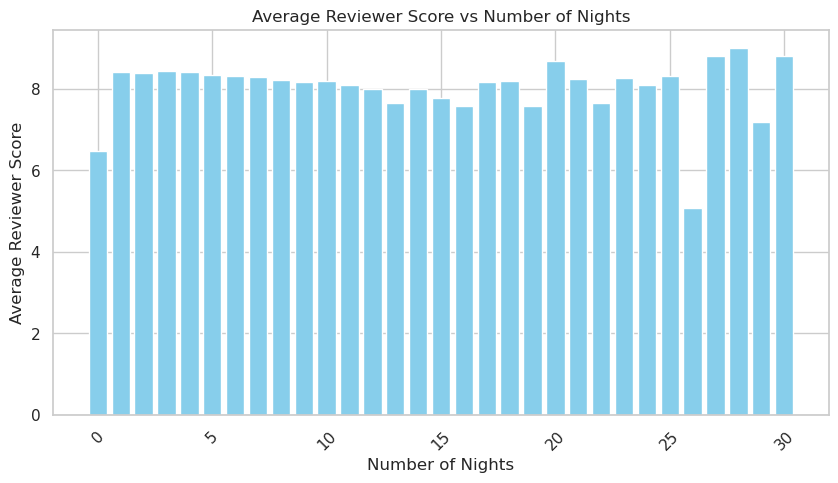

In [54]:
import matplotlib.pyplot as plt

# Aggregate: mean reviewer score per number of nights
avg_score_by_nights = sampled_hotels.groupby('nights')['reviewer_score'].mean()

plt.figure(figsize=(10,5))
plt.bar(avg_score_by_nights.index, avg_score_by_nights.values, color='skyblue')
plt.title('Average Reviewer Score vs Number of Nights')
plt.xlabel('Number of Nights')
plt.ylabel('Average Reviewer Score')
plt.xticks(rotation=45)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


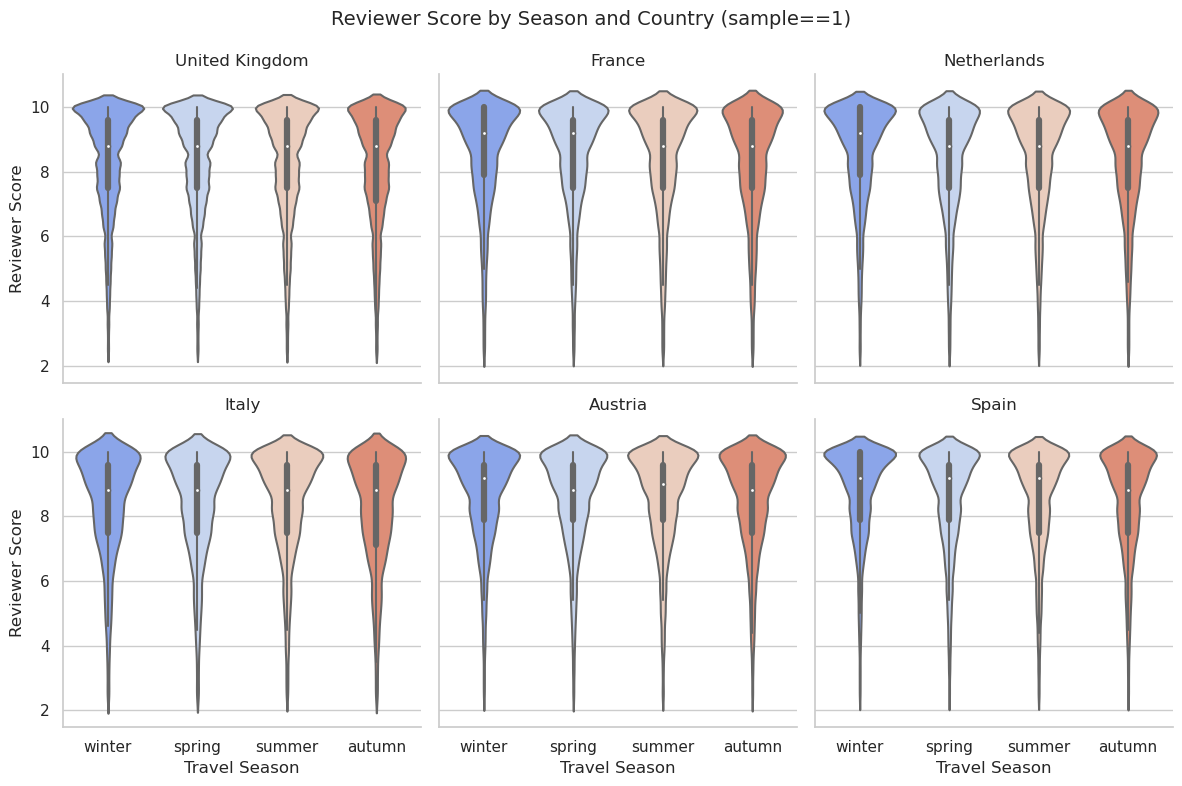

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define season order
season_order = ['winter', 'spring', 'summer', 'autumn']

# Limit to top N countries (optional, to keep it readable)
top_countries = sampled_hotels['hotel_country'].value_counts().nlargest(6).index
subset = sampled_hotels[sampled_hotels['hotel_country'].isin(top_countries)]

# Faceted violin plot
g = sns.FacetGrid(subset, col='hotel_country', col_wrap=3, height=4, sharey=True)
g.map_dataframe(
    sns.violinplot,
    x='season',
    y='reviewer_score',
    order=season_order,
    palette='coolwarm'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Travel Season", "Reviewer Score")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Reviewer Score by Season and Country (sample==1)", fontsize=14)
plt.show()


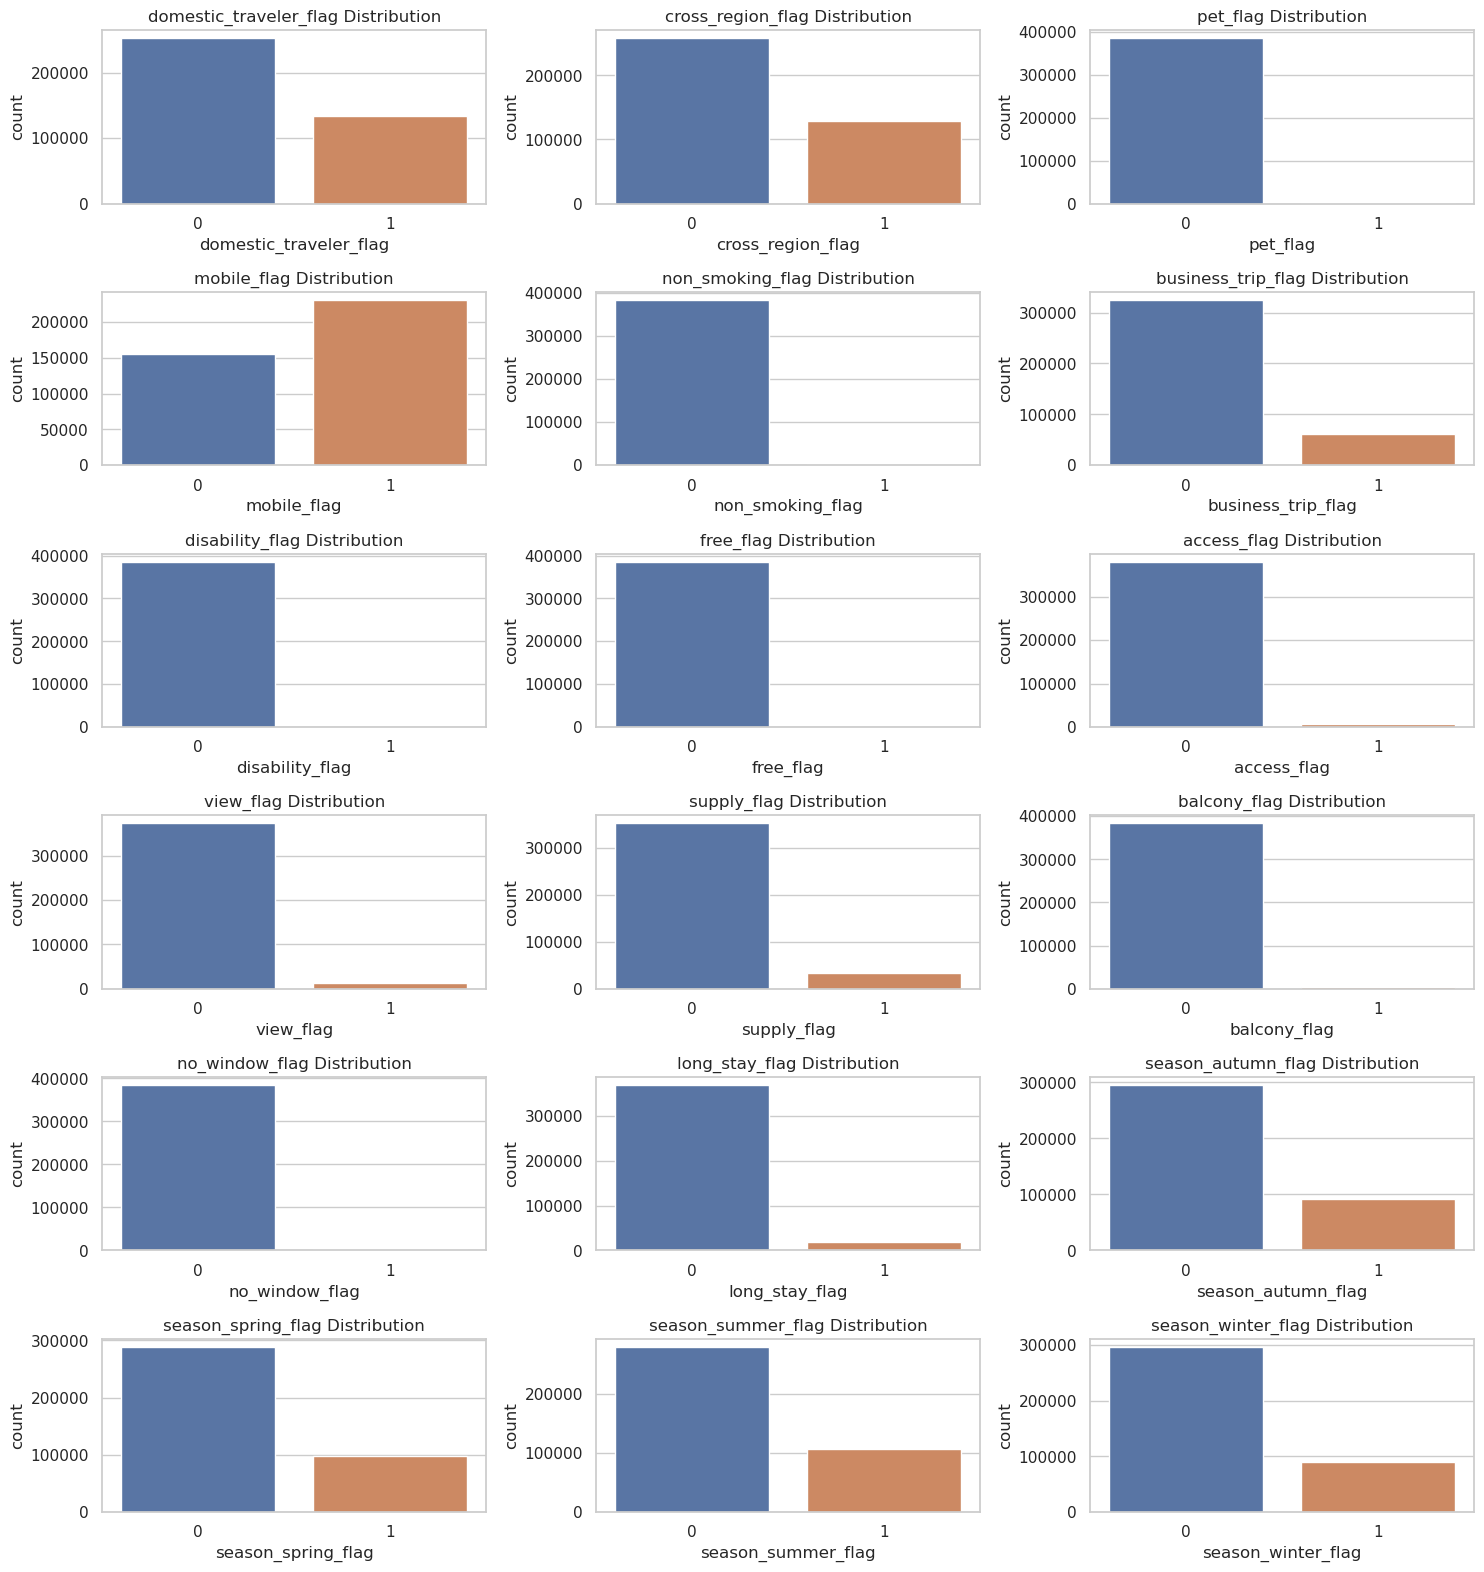

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all _flag columns
flag_cols = [col for col in sampled_hotels.columns if col.endswith('_flag')]

# Plot distributions side by side
fig, axes = plt.subplots(len(flag_cols)//3 + 1, 3, figsize=(15, len(flag_cols)))
axes = axes.flatten()

for i, col in enumerate(flag_cols):
    sns.countplot(x=col, data=sampled_hotels, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')

# Remove empty axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



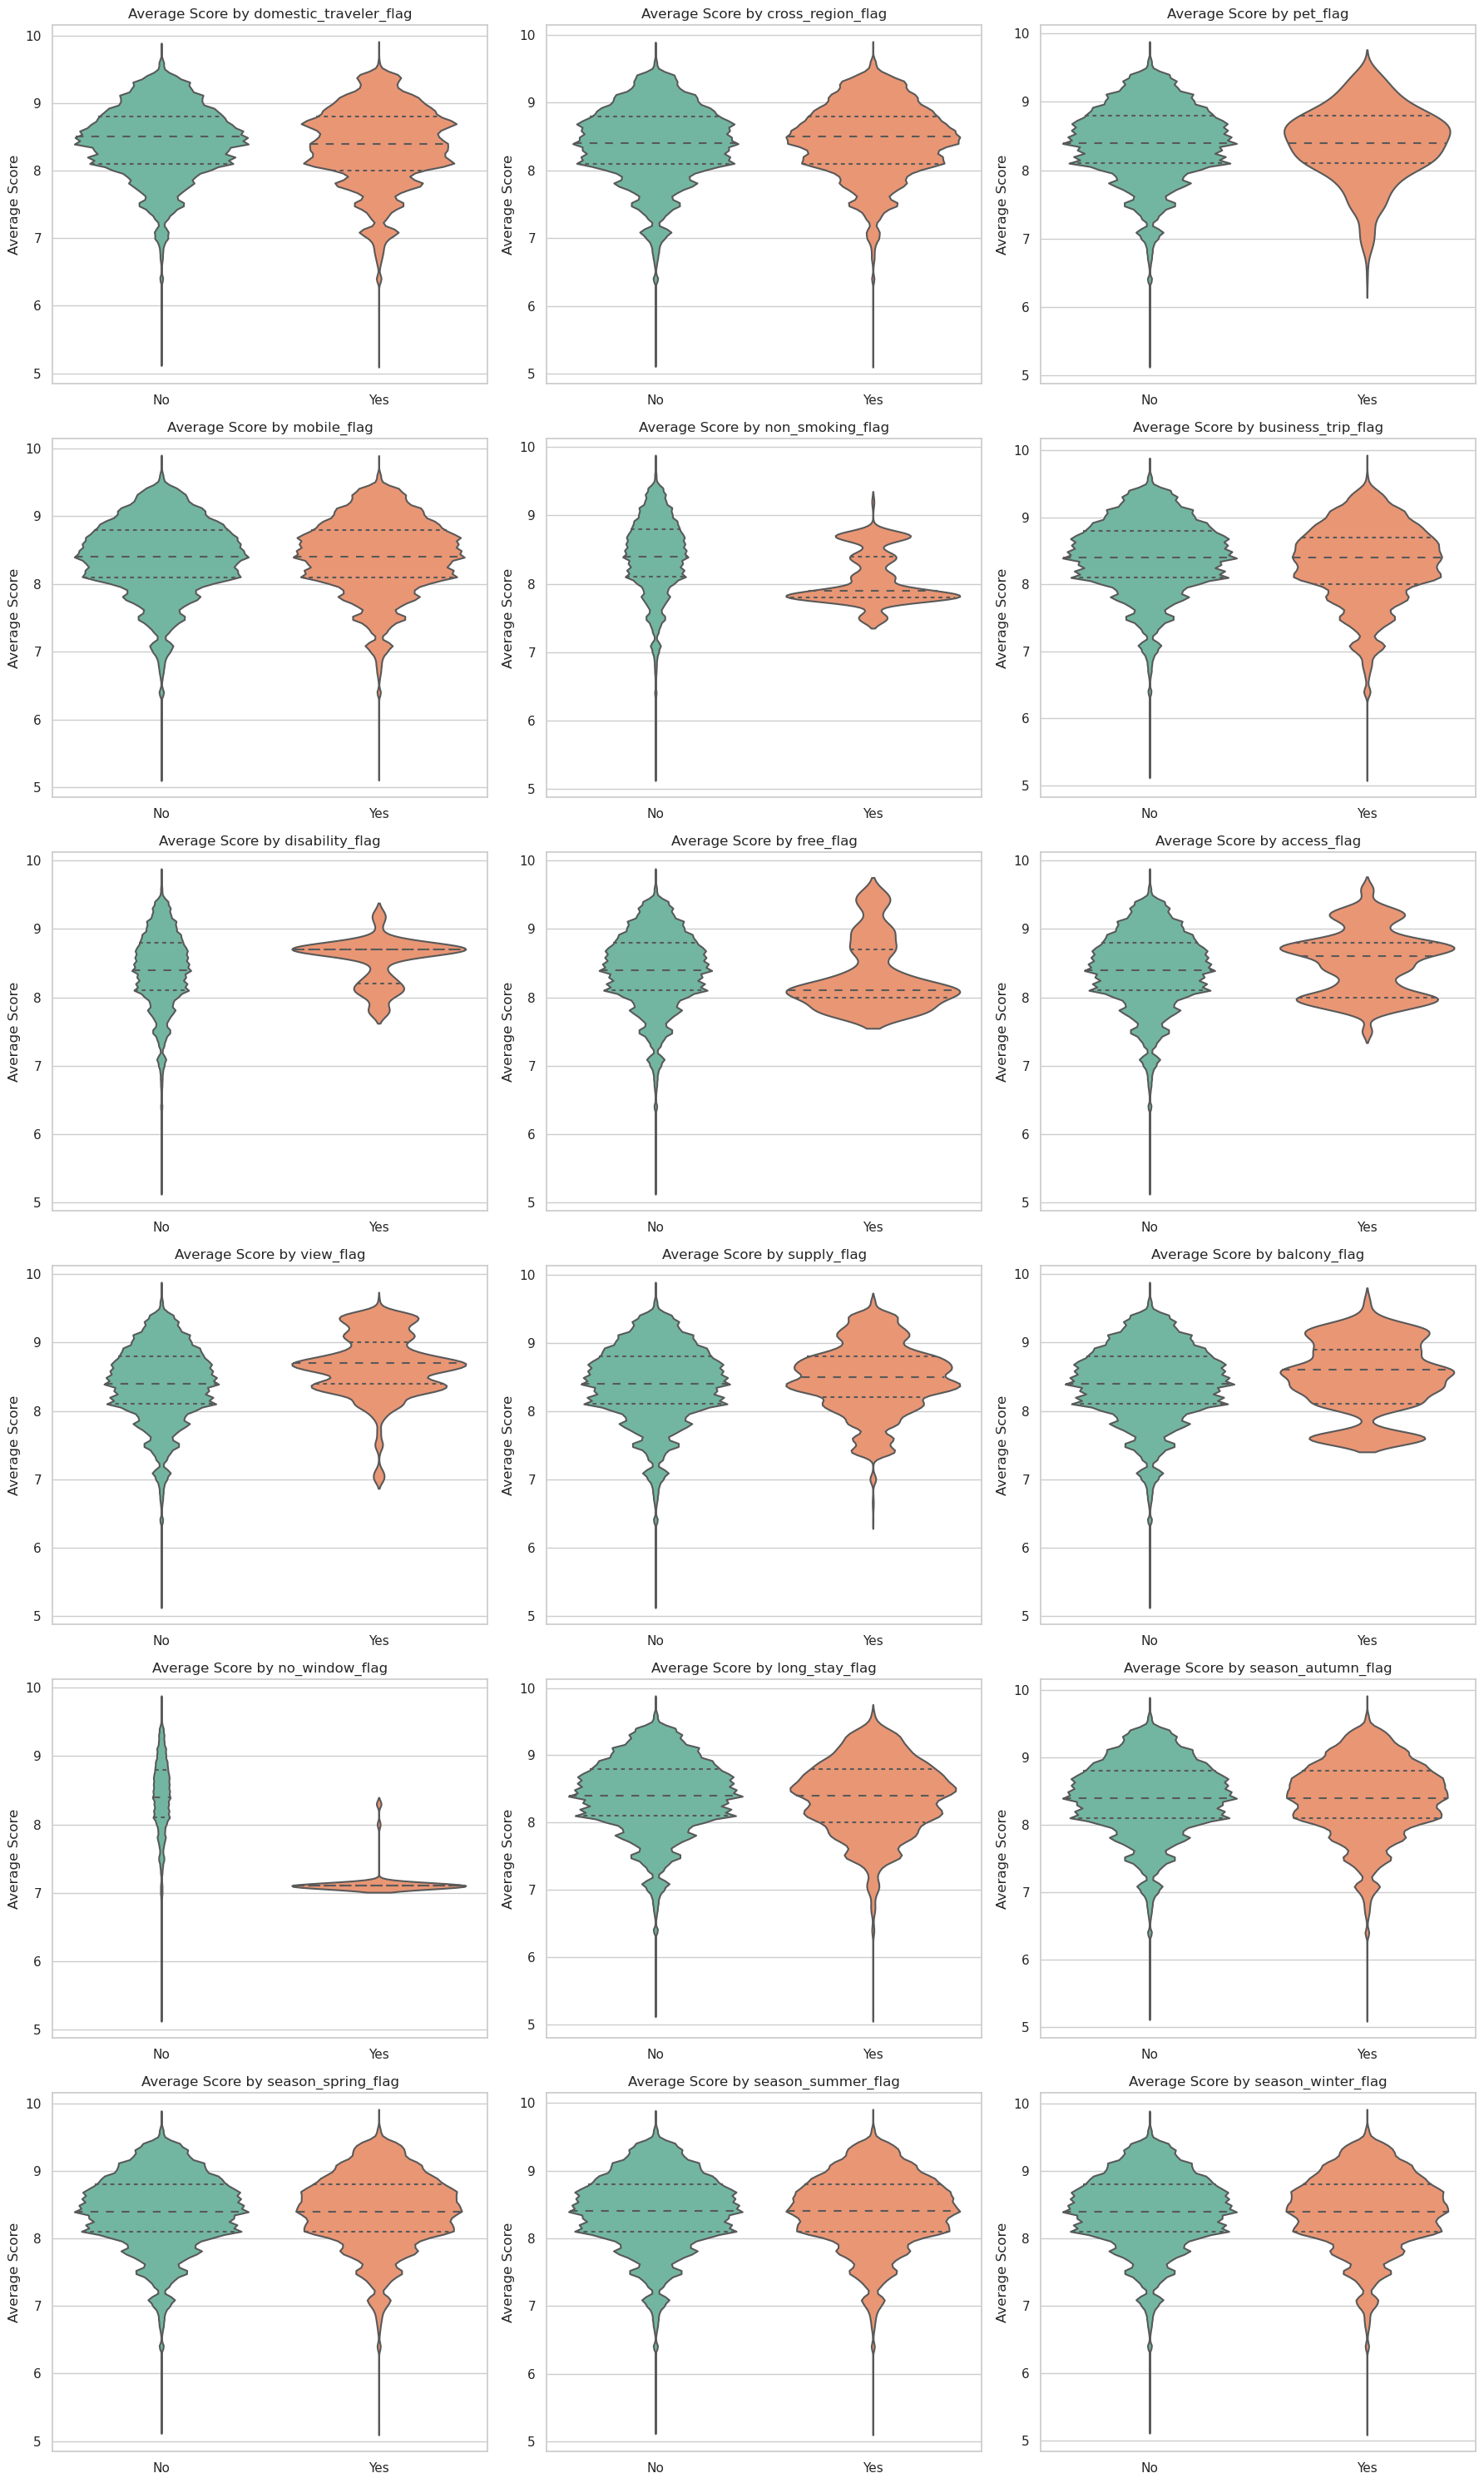

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns ending with '_flag'
flag_cols = [col for col in sampled_hotels.columns if col.endswith('_flag')]

# Set up the plot grid
n_flags = len(flag_cols)
n_cols = 3  # number of subplots per row
n_rows = (n_flags + n_cols - 1) // n_cols  # calculate rows needed

plt.figure(figsize=(n_cols*6, n_rows*5))

for i, flag in enumerate(flag_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(
        x=flag,
        y='average_score',
        data=sampled_hotels,
        inner='quartile',
        palette=['#66c2a5','#fc8d62']
    )
    plt.xticks([0,1], ['No','Yes'])
    plt.title(f'Average Score by {flag}')
    plt.xlabel('')
    plt.ylabel('Average Score')

plt.tight_layout()
plt.show()


In [58]:
other_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.difference(flag_cols)
other_cols

Index(['additional_number_of_scoring', 'adjusted_score', 'average_score',
       'avg_score_times_additional_scoring', 'avg_score_times_total_reviews',
       'days_since_review', 'distance_from_city_center', 'distance_zone',
       'lat', 'lng', 'negative_score', 'nights', 'popularity_index',
       'pos_to_neg_ratio', 'pos_to_neg_ratio_log', 'pos_vs_neg_words',
       'positive_score', 'positive_to_negative_ratio', 'rating_only_ratio',
       'recency_weight', 'review_density', 'review_total_negative_word_counts',
       'review_total_positive_word_counts', 'reviewer_bias',
       'reviewer_experience', 'reviewer_score', 'room_capacity',
       'room_quality_level', 'sample', 'score_deviation', 'score_difference',
       'total_feedback_count', 'total_number_of_reviews',
       'total_number_of_reviews_reviewer_has_given', 'travel_month',
       'travel_year', 'traveler_type'],
      dtype='object')

In [59]:
#n_hotels.drop('tag_list', axis=1, inplace=True)


In [60]:
# ==========================
# Identify categorical and numeric columns
# ==========================

# categorical features
cat_cols = [ 'sample', 'distance_zone', 'traveler_type', 'room_capacity', 'room_quality_level',]

# numerical features
num_cols = other_cols.difference(cat_cols) #list(n_hotels.drop(columns=cat_cols, axis=1))

num_cols, cat_cols

(Index(['additional_number_of_scoring', 'adjusted_score', 'average_score',
        'avg_score_times_additional_scoring', 'avg_score_times_total_reviews',
        'days_since_review', 'distance_from_city_center', 'lat', 'lng',
        'negative_score', 'nights', 'popularity_index', 'pos_to_neg_ratio',
        'pos_to_neg_ratio_log', 'pos_vs_neg_words', 'positive_score',
        'positive_to_negative_ratio', 'rating_only_ratio', 'recency_weight',
        'review_density', 'review_total_negative_word_counts',
        'review_total_positive_word_counts', 'reviewer_bias',
        'reviewer_experience', 'reviewer_score', 'score_deviation',
        'score_difference', 'total_feedback_count', 'total_number_of_reviews',
        'total_number_of_reviews_reviewer_has_given', 'travel_month',
        'travel_year'],
       dtype='object'),
 ['sample',
  'distance_zone',
  'traveler_type',
  'room_capacity',
  'room_quality_level'])

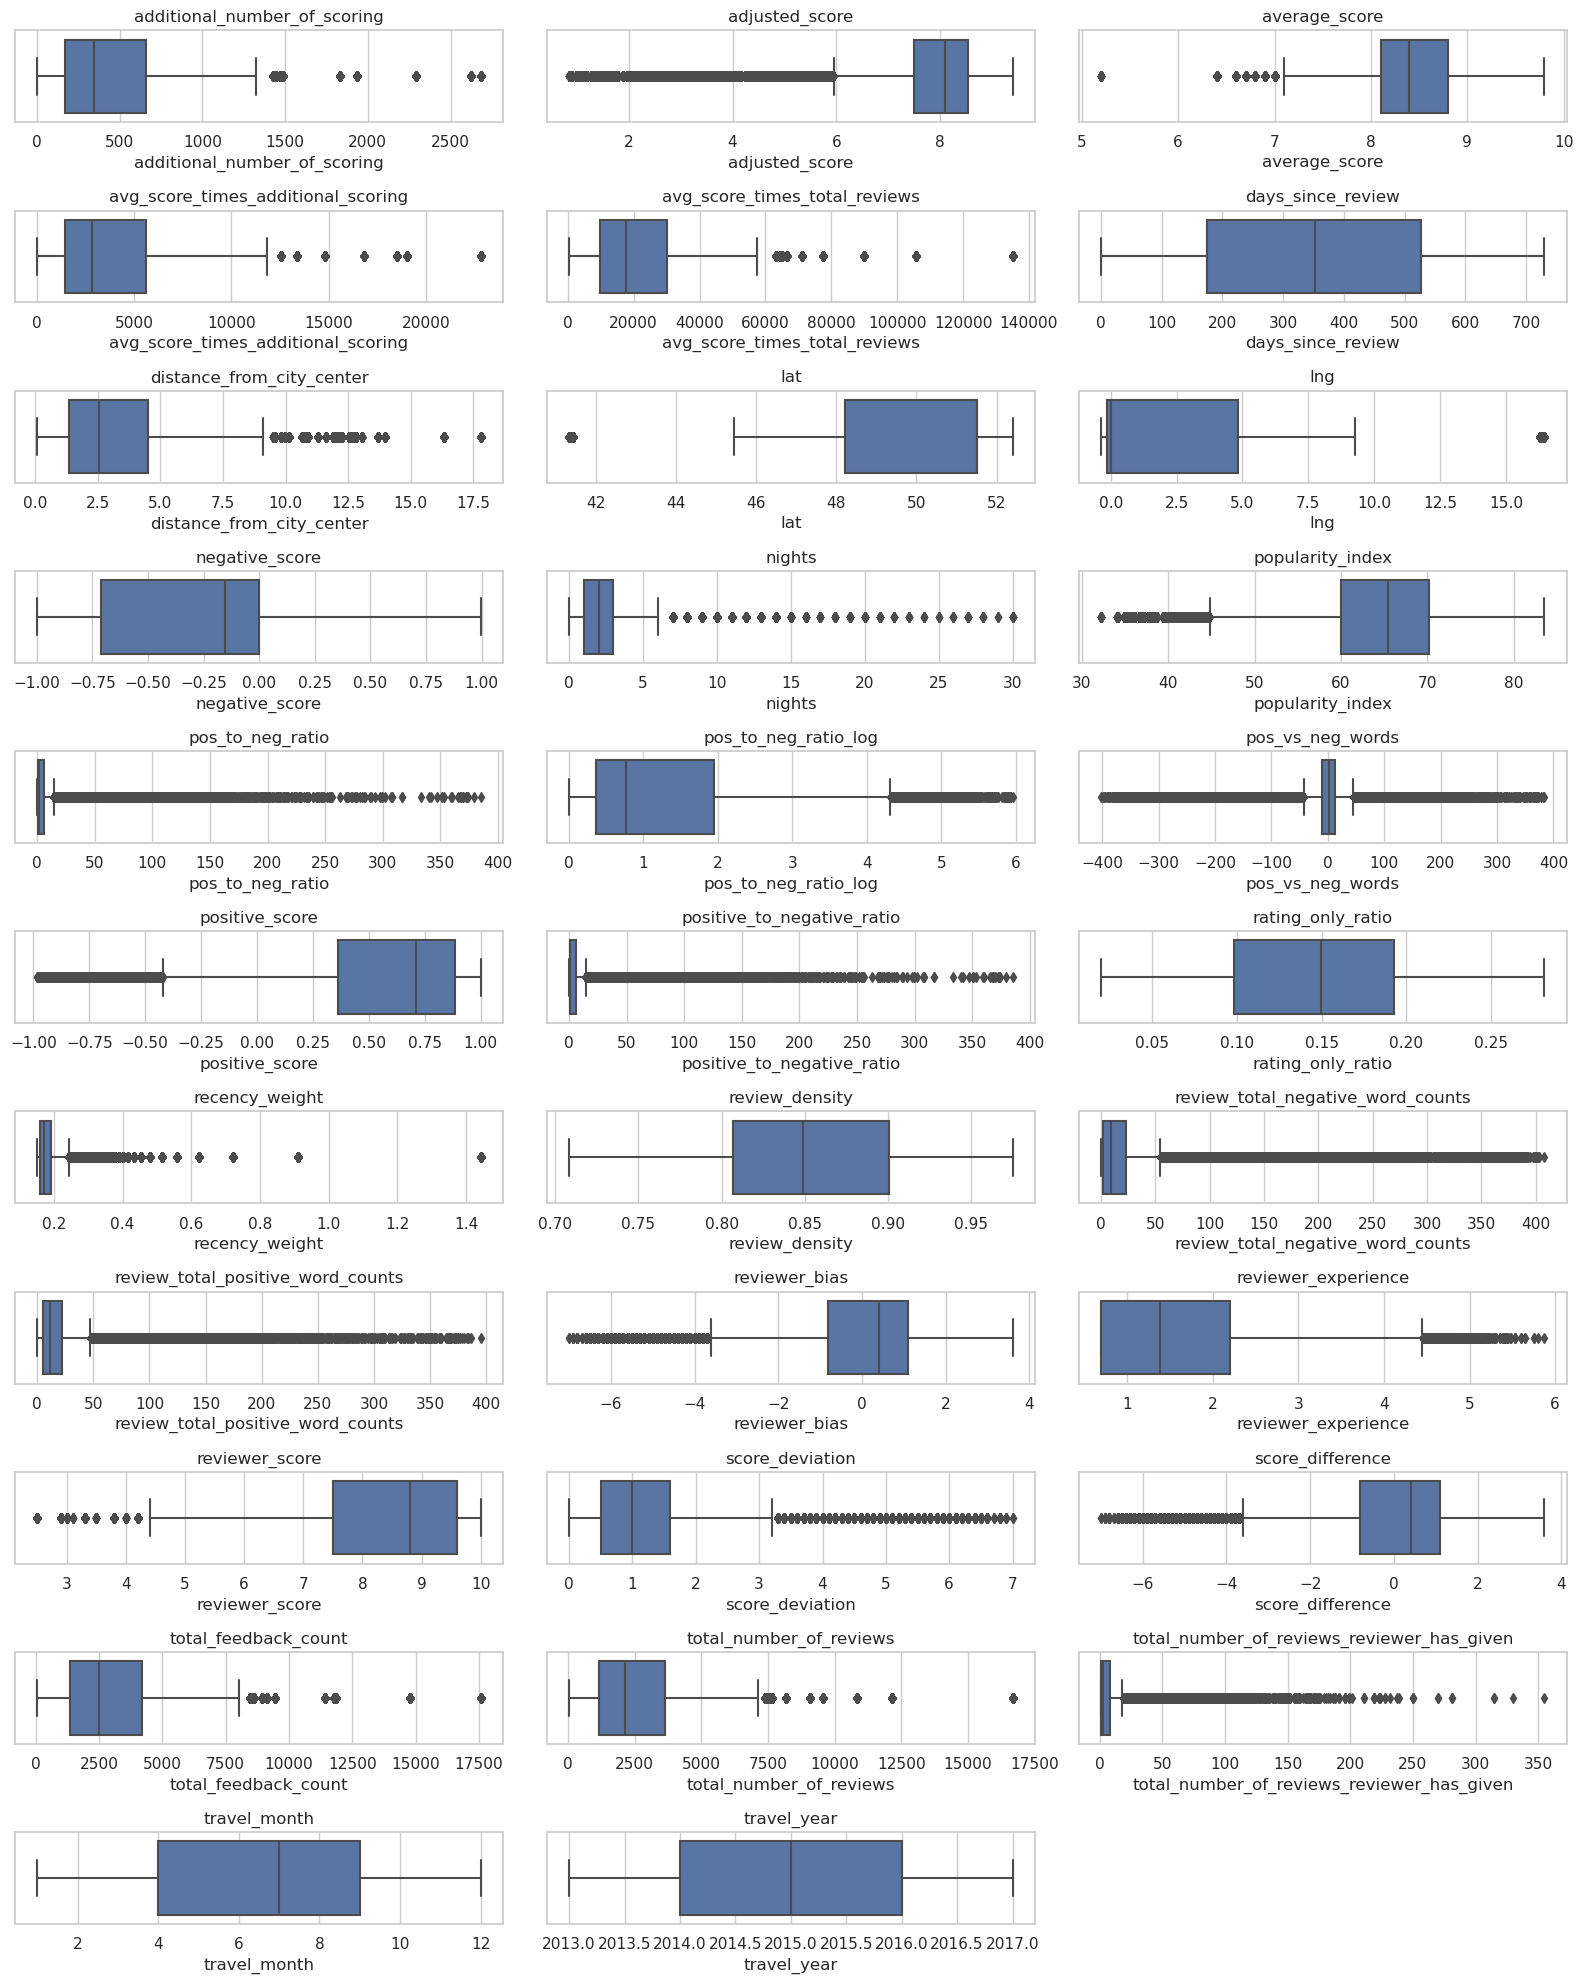

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

#num_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(x=sampled_hotels[col])
    plt.title(col)
plt.tight_layout()
plt.show()


## Outliers

**Tree-based models** split by thresholds, so extreme values won’t “pull” the model the way they would in regression.

In [62]:
'''
#   3-sigma method (Tukey's method) to identify outliers in numerical features
import pandas as pd

def outliers_iqr(data, feature, k=3.0):
    """Detect and remove outliers using the Tukey IQR method."""
    x = data[feature]
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Create a cleaned copy of the dataset
data_cleaner = n_hotels.copy()

# Loop through numeric columns
for feature in num_cols:
    outliers, cleaned = outliers_iqr(data_cleaner, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    data_cleaner = cleaned  # progressively clean the dataset

'''

'\n#   3-sigma method (Tukey\'s method) to identify outliers in numerical features\nimport pandas as pd\n\ndef outliers_iqr(data, feature, k=3.0):\n    """Detect and remove outliers using the Tukey IQR method."""\n    x = data[feature]\n    q1, q3 = x.quantile(0.25), x.quantile(0.75)\n    iqr = q3 - q1\n    lower_bound = q1 - k * iqr\n    upper_bound = q3 + k * iqr\n    outliers = data[(x < lower_bound) | (x > upper_bound)]\n    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]\n    return outliers, cleaned\n\n# Create a cleaned copy of the dataset\ndata_cleaner = n_hotels.copy()\n\n# Loop through numeric columns\nfor feature in num_cols:\n    outliers, cleaned = outliers_iqr(data_cleaner, feature, k=3)\n    print(f"{feature}: removed {len(outliers)} outliers")\n    data_cleaner = cleaned  # progressively clean the dataset\n\n'

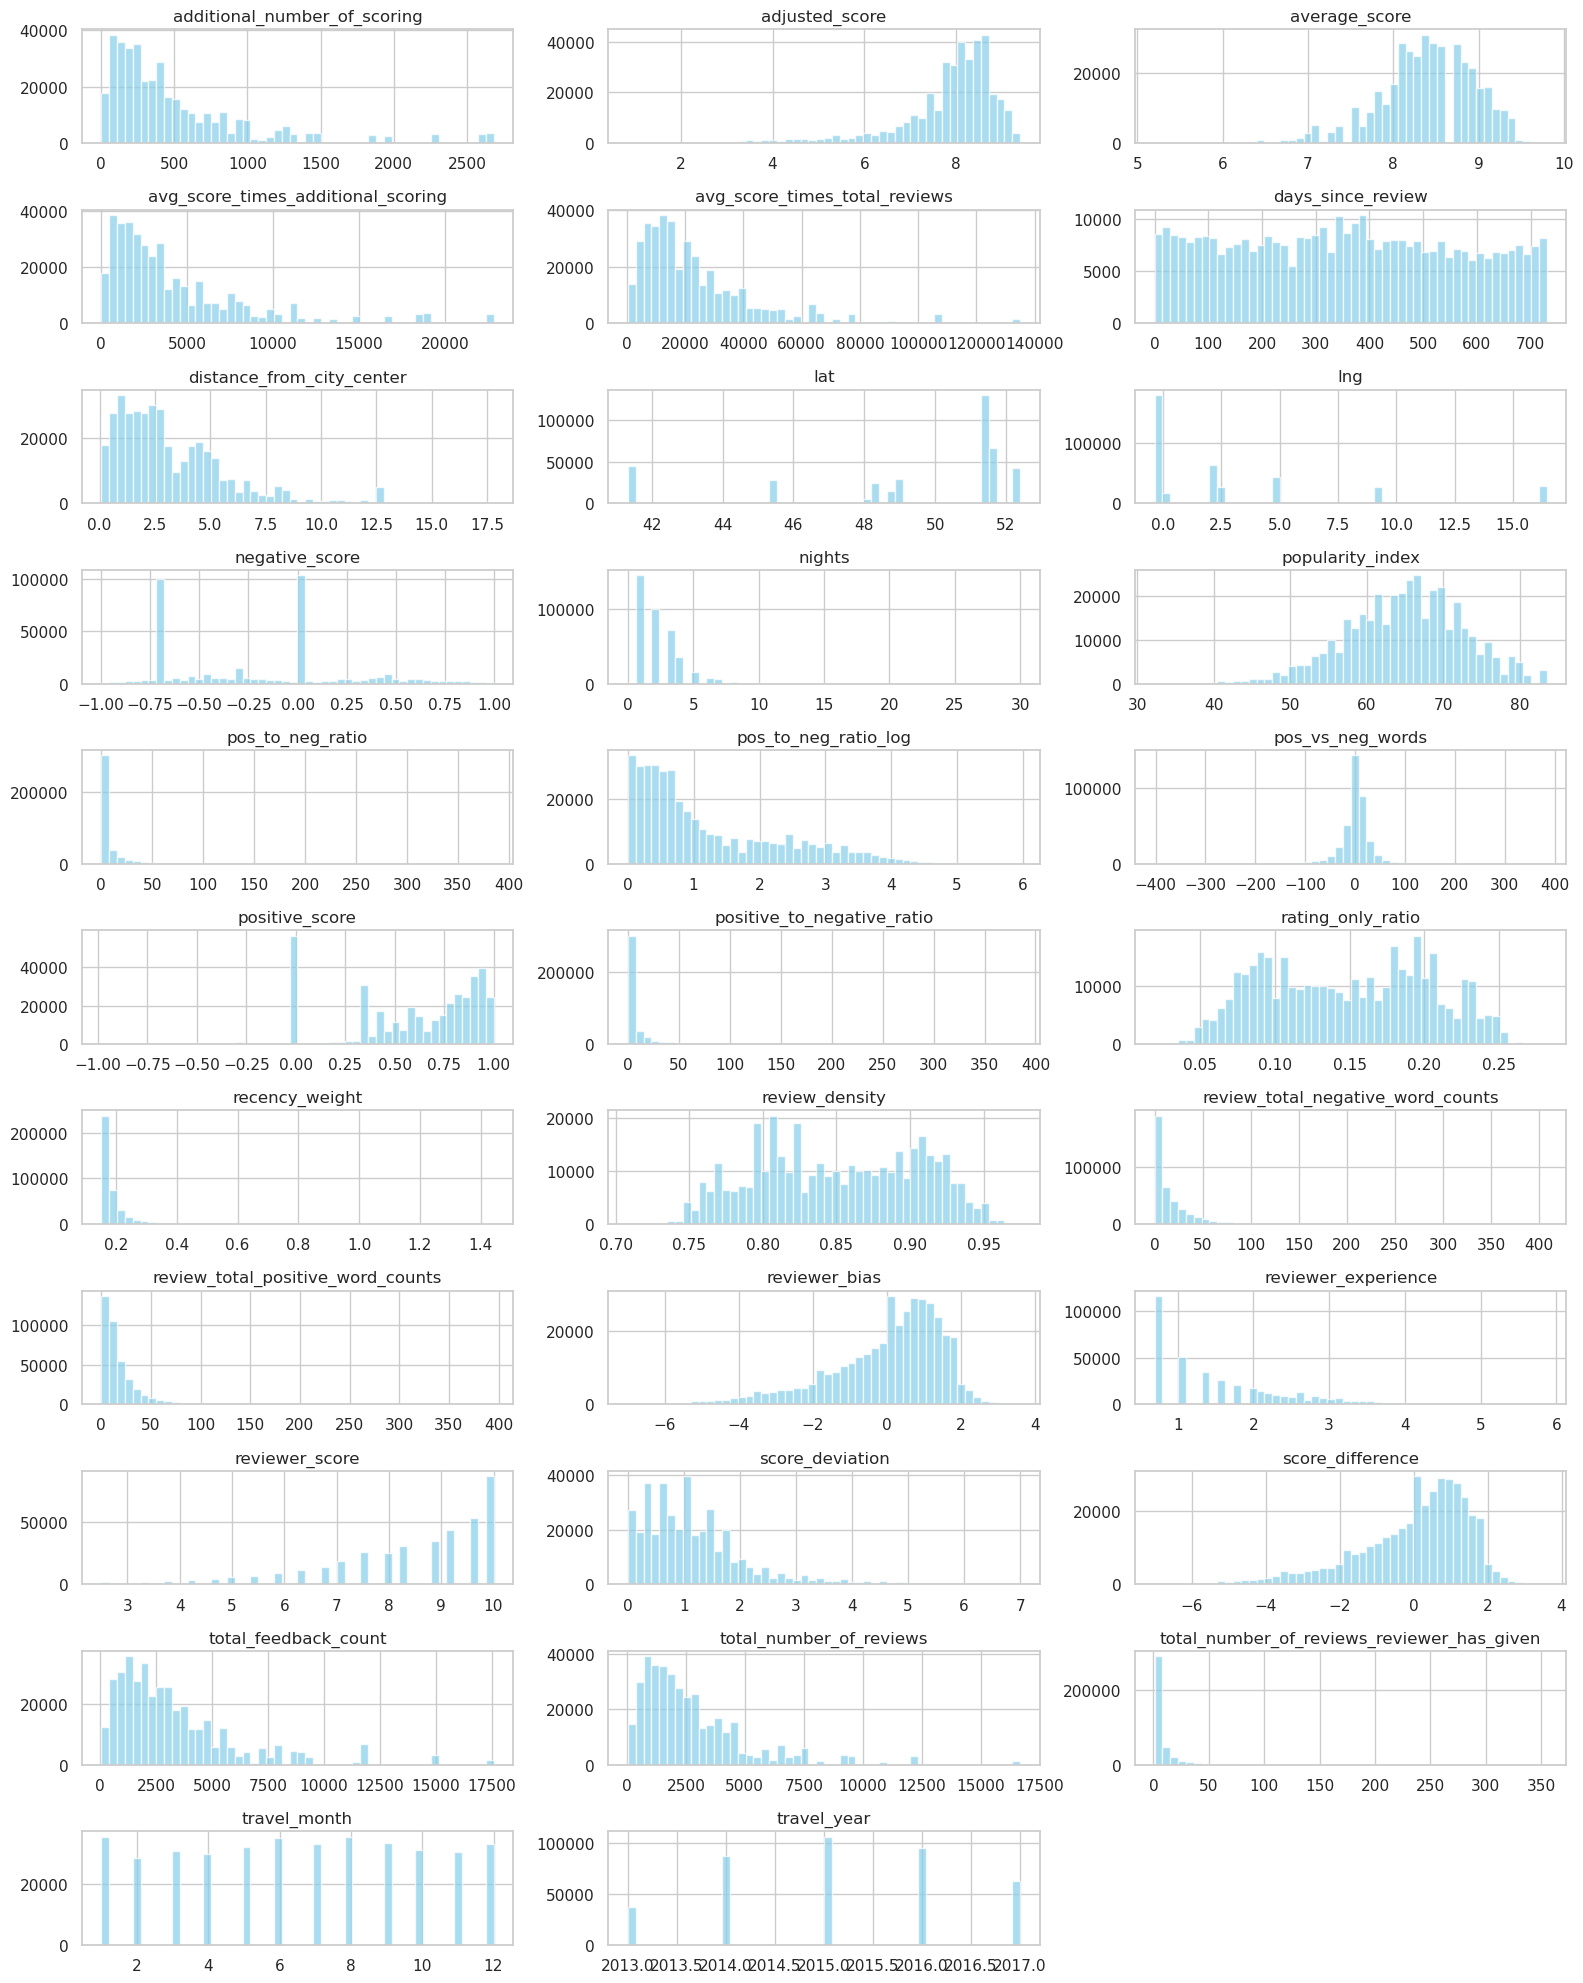

In [63]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    plt.hist(x=sampled_hotels[col], bins=50, color='skyblue', alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()

In [64]:
"""import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Before cleaning
    axes[i, 0].hist(n_hotels[col], bins=50, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'{col} — Before Cleaning')

    # After cleaning
    axes[i, 1].hist(data_cleaner[col], bins=50, color='lightgreen', alpha=0.7)
    axes[i, 1].set_title(f'{col} — After Cleaning')

plt.tight_layout()
plt.show()"""

"import matplotlib.pyplot as plt\n\nfig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))\n\nfor i, col in enumerate(num_cols):\n    # Before cleaning\n    axes[i, 0].hist(n_hotels[col], bins=50, color='skyblue', alpha=0.7)\n    axes[i, 0].set_title(f'{col} — Before Cleaning')\n\n    # After cleaning\n    axes[i, 1].hist(data_cleaner[col], bins=50, color='lightgreen', alpha=0.7)\n    axes[i, 1].set_title(f'{col} — After Cleaning')\n\nplt.tight_layout()\nplt.show()"

In [65]:
"""# Create a cleaned copy of the dataset
n_hotels_cleaner = n_hotels.copy()

# It seems like, some of the features do require outlier cleaning
# --- Apply cleaning only to selected columns ---
out_cols = [
    'total_number_of_reviews',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'nights'
]

for feature in out_cols:
    outliers, cleaned = outliers_iqr(n_hotels, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    n_hotels_cleaner = cleaned  # progressively remove outliers"""

'# Create a cleaned copy of the dataset\nn_hotels_cleaner = n_hotels.copy()\n\n# It seems like, some of the features do require outlier cleaning\n# --- Apply cleaning only to selected columns ---\nout_cols = [\n    \'total_number_of_reviews\',\n    \'review_total_negative_word_counts\',\n    \'review_total_positive_word_counts\',\n    \'total_number_of_reviews_reviewer_has_given\',\n    \'nights\'\n]\n\nfor feature in out_cols:\n    outliers, cleaned = outliers_iqr(n_hotels, feature, k=3)\n    print(f"{feature}: removed {len(outliers)} outliers")\n    n_hotels_cleaner = cleaned  # progressively remove outliers'

## Scaling

For numeric features that vary a lot in magnitude and will otherwise dominate distance-based or linear models.

**Tree-based models** (RandomForest, XGBoost, etc.) are scale-invariant, so scaling is not needed.
However, if you’ll use regression, PCA, or neural networks, scaling is highly recommended.


In [66]:
'''
to_scale = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'nights',
    'days_since_review_n'
]
no_scale = [
    'average_score',
    'reviewer_score',
    'lat', 'lng',
    'lat_nationality', 'lng_nationality',
    'year'
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
n_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])
'''

"\nto_scale = [\n    'additional_number_of_scoring',\n    'review_total_negative_word_counts',\n    'review_total_positive_word_counts',\n    'total_number_of_reviews',\n    'total_number_of_reviews_reviewer_has_given',\n    'nights',\n    'days_since_review_n'\n]\nno_scale = [\n    'average_score',\n    'reviewer_score',\n    'lat', 'lng',\n    'lat_nationality', 'lng_nationality',\n    'year'\n]\n\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nn_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])\n"

In [67]:
'''

import numpy as np

def cap_outliers(df, columns, factor=1.5):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        # cap values
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))
    return df

n_hotels[num_cols] = cap_outliers(n_hotels, num_cols)

'''

'\n\nimport numpy as np\n\ndef cap_outliers(df, columns, factor=1.5):\n    df = df.copy()\n    for col in columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower = Q1 - factor * IQR\n        upper = Q3 + factor * IQR\n        # cap values\n        df[col] = np.where(df[col] < lower, lower,\n                           np.where(df[col] > upper, upper, df[col]))\n    return df\n\nn_hotels[num_cols] = cap_outliers(n_hotels, num_cols)\n\n'

## Create interaction features

## Correlation map

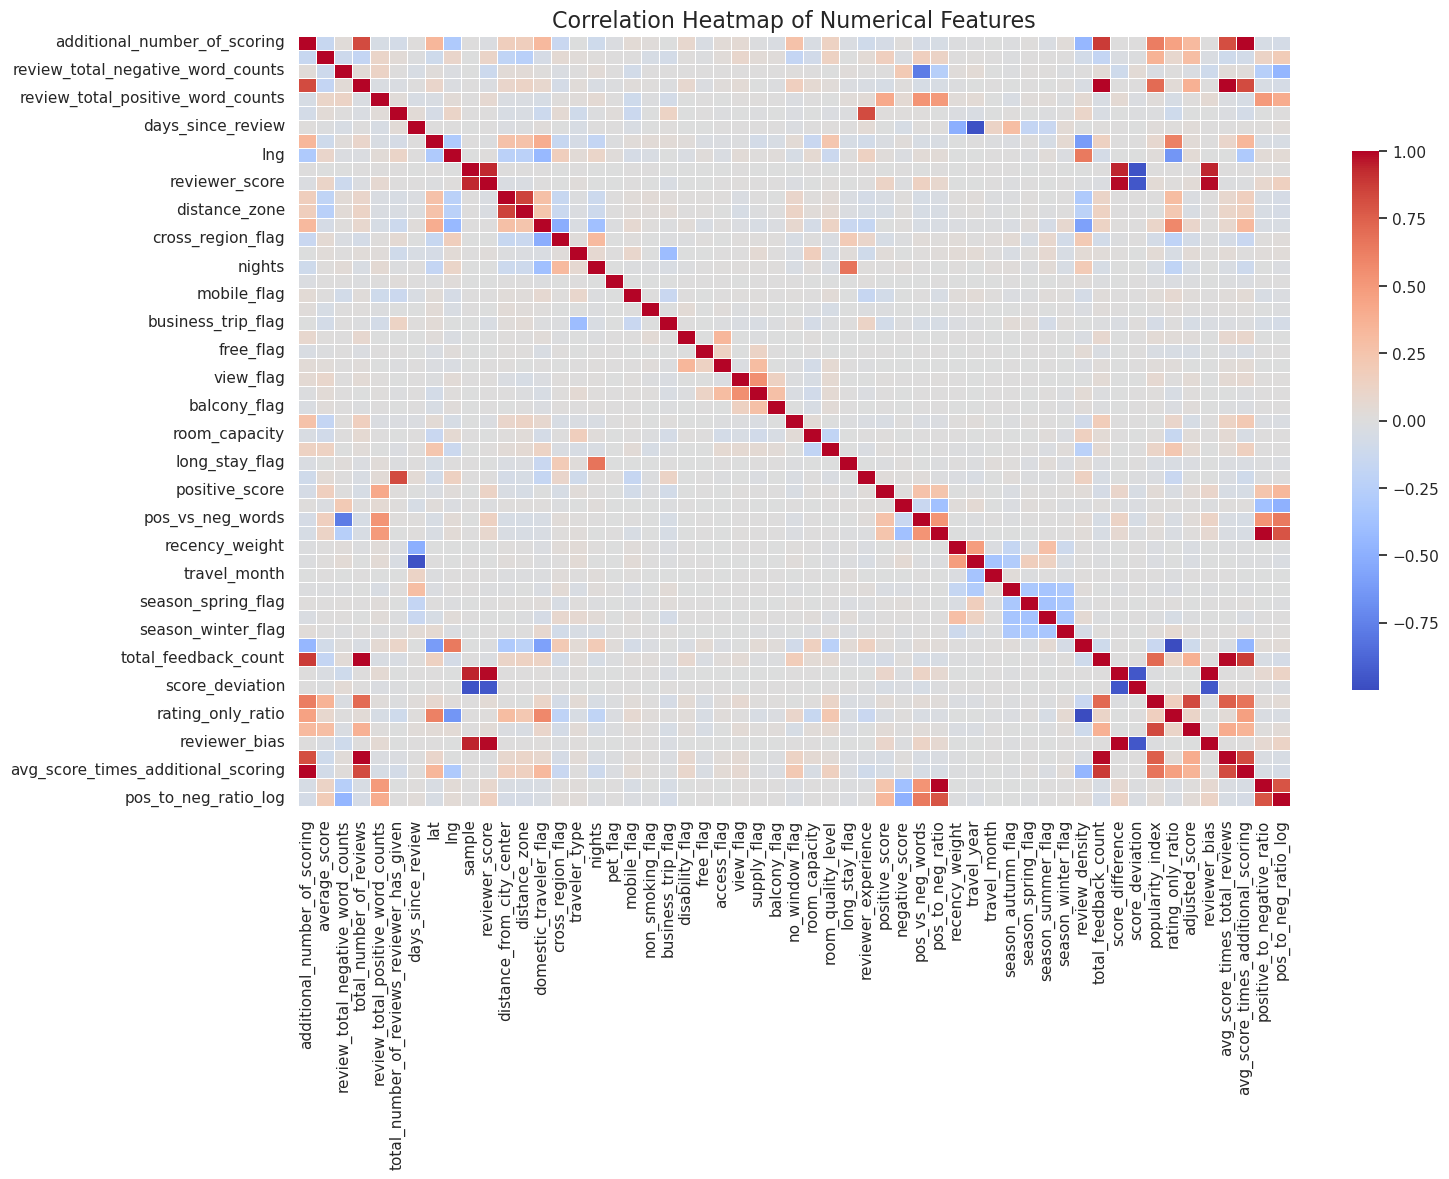

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation only for numerical columns
corr = n_hotels.select_dtypes(include=['number']).corr()

# Create a better visual
plt.figure(figsize=(16,10))
sns.heatmap(
    corr, 
    cmap='coolwarm',       # better contrast
    center=0,              # zero-centered colors
    annot=False,           # can set True for small matrices
    linewidths=0.5,
    cbar_kws={'shrink': .7}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

reviewer_bias                                 0.990100
score_difference                              0.990100
pos_to_neg_ratio_log                          0.149641
pos_vs_neg_words                              0.146670
positive_score                                0.119355
average_score                                 0.113686
pos_to_neg_ratio                              0.083248
positive_to_negative_ratio                    0.083248
review_total_positive_word_counts             0.069021
popularity_index                              0.041402
adjusted_score                                0.033787
lng                                           0.009882
rating_only_ratio                             0.009334
total_number_of_reviews_reviewer_has_given    0.002396
reviewer_experience                           0.002230
travel_month                                  0.001700
days_since_review                             0.000225
travel_year                                  -0.000660
recency_we

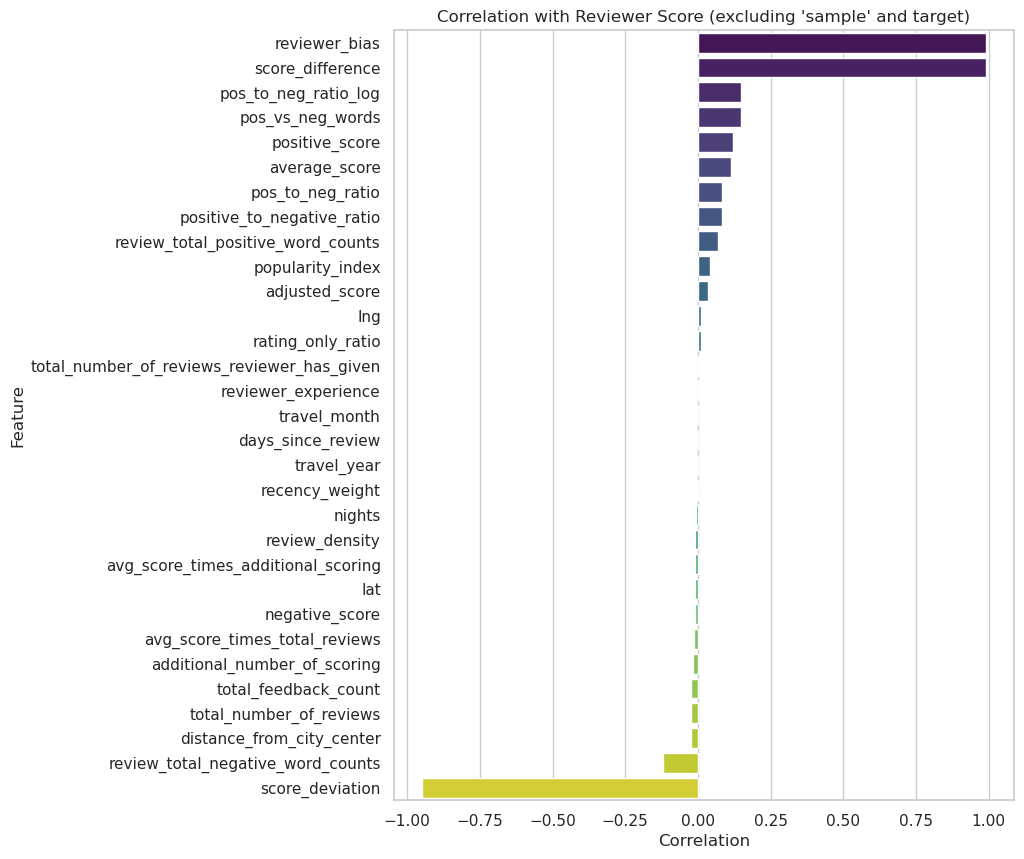

In [69]:
# Compute correlations
corr = n_hotels[num_cols].corr()

# Drop 'sample' and the target itself
feature_x='reviewer_score'
target_corr = corr[feature_x].drop([feature_x, 'sample'], errors='ignore')

# Sort correlations by absolute value (optional — helps visualize strongest relationships)
target_corr = target_corr.sort_values(ascending=False)

# Display values
print(target_corr)

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(y=target_corr.index, x=target_corr.values, palette='viridis')
plt.title("Correlation with Reviewer Score (excluding 'sample' and target)")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


# Train/Test Split and Model Training

In [70]:
#n_hotels = n_hotels.select_dtypes(include=['number'])
data_chosen = n_hotels.select_dtypes(include=['number'])
#data_chosen = n_hotels_cleaner.copy()

In [71]:
data_chosen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   days_since_review                           515431 non-null  int64  
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

In [72]:
# =====================================================
# 10. Train/Test Split, Encoding, and Model Training
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd

# Separate train and test data
train_data = data_chosen.query('sample == 1').drop(['sample'], axis=1)
test_data = data_chosen.query('sample == 0').drop(['sample'], axis=1)

# Target and features
y = train_data['reviewer_score']
X = train_data.drop(['reviewer_score'], axis=1)

In [73]:
test_data['reviewer_score']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
128930    0.0
128931    0.0
128932    0.0
128933    0.0
128934    0.0
Name: reviewer_score, Length: 128935, dtype: float64

In [74]:
# ==========================
# Split train data into train/test sets
# ==========================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# Optional: Scale numeric features (not required for Random Forest)
# ==========================
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)



#  Hyperparameter tuning

In [75]:
# ==========================
# Train Random Forest Model
# ==========================
#rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#rf.fit(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100], #, 200, 500
    'max_depth': [30], #None, 10, 20, 30
    #'min_samples_split': [2],#, 5, 10
    #'min_samples_leaf': [ 4], #1, 2,
    #'max_features': ['auto']#, 'sqrt', 'log2'
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid,
                            n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
search.fit(X_train, y_train)

best_rf = search.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [76]:
best_rf = search.best_estimator_

In [77]:
# ==========================
# Evaluate model
# ==========================
y_pred = best_rf.predict(X_valid)
mape = metrics.mean_absolute_percentage_error(y_valid, y_pred) * 100
mae = metrics.mean_absolute_error(y_valid, y_pred)
rmse = metrics.mean_squared_error(y_valid, y_pred, squared=False)
r2 = metrics.r2_score(y_valid, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"Test MAPE: {mape:.2f}%")
#MAE: 0.86
#RMSE: 1.15
#R²: 0.500
#Test MAPE: 12.39%

MAE: 0.00
RMSE: 0.01
R²: 1.000
Test MAPE: 0.01%


In [78]:
print(best_rf.get_params()['n_estimators'])
print(best_rf.get_params()['max_depth'])
print(best_rf.get_params()['min_samples_split'])
print(best_rf.get_params()['min_samples_leaf'])
print(best_rf.get_params()['max_features'])

100
30
2
1
1.0


# Visual inspection

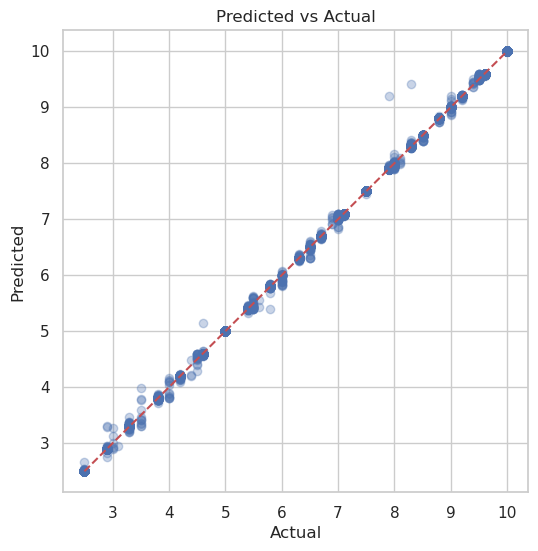

In [79]:
import matplotlib.pyplot as plt
y_true = y_valid.values

plt.figure(figsize=(6,6))
plt.scatter(y_true[:], y_pred[:], alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## (Optional) Feature Importance Plot

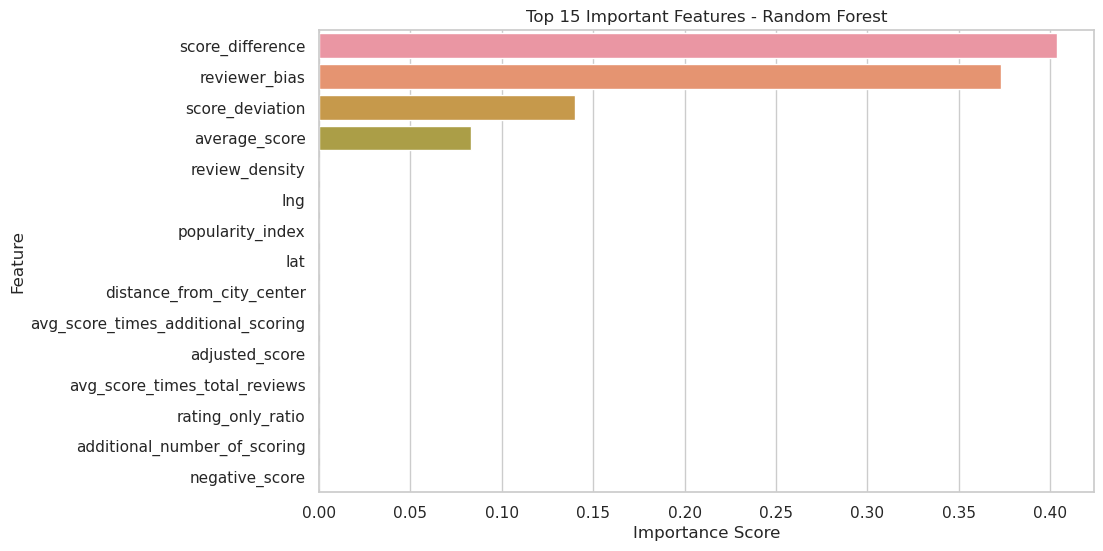

In [80]:
# =====================================================
# 12. Feature Importance Visualization
# =====================================================
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title('Top 15 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Submission

In [81]:
test_data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'reviewer_score', 'distance_from_city_center',
       'distance_zone', 'domestic_traveler_flag', 'cross_region_flag',
       'traveler_type', 'nights', 'pet_flag', 'mobile_flag',
       'non_smoking_flag', 'business_trip_flag', 'disability_flag',
       'free_flag', 'access_flag', 'view_flag', 'supply_flag', 'balcony_flag',
       'no_window_flag', 'room_capacity', 'room_quality_level',
       'long_stay_flag', 'reviewer_experience', 'positive_score',
       'negative_score', 'pos_vs_neg_words', 'pos_to_neg_ratio',
       'recency_weight', 'travel_year', 'travel_month', 'season_autumn_flag',
       'season_spring_flag', 'season_summer_flag', 'season_winter_flag',
       'review_density', 'total_feedback_count', 'score_differ

In [82]:
train_data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'reviewer_score', 'distance_from_city_center',
       'distance_zone', 'domestic_traveler_flag', 'cross_region_flag',
       'traveler_type', 'nights', 'pet_flag', 'mobile_flag',
       'non_smoking_flag', 'business_trip_flag', 'disability_flag',
       'free_flag', 'access_flag', 'view_flag', 'supply_flag', 'balcony_flag',
       'no_window_flag', 'room_capacity', 'room_quality_level',
       'long_stay_flag', 'reviewer_experience', 'positive_score',
       'negative_score', 'pos_vs_neg_words', 'pos_to_neg_ratio',
       'recency_weight', 'travel_year', 'travel_month', 'season_autumn_flag',
       'season_spring_flag', 'season_summer_flag', 'season_winter_flag',
       'review_density', 'total_feedback_count', 'score_differ

In [83]:
predict_submission = best_rf.predict(test_data.drop(['reviewer_score'], axis=1))
print(len(predict_submission)) 
len(sample_submission)


128935


128935

In [84]:
#sample_submission = pd.read_csv( DATA_DIR + 'submission.csv' ) # самбмишн

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_pred.csv', index=False)
sample_submission

,reviewer_score,id
0,2.500,488440
1,2.500,274649
2,2.500,374688
3,2.528,404352
4,2.508,451596
...,...,...
128930,2.500,495812
128931,2.500,315577
128932,2.500,511968
128933,2.504,303386
